In [169]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(1, '/home/jw3514/Work/CellType_Psy/src')
from CellType_PSY import *
import scanpy as sc
HGNC, ENSID2Entrez, GeneSymbol2Entrez, Entrez2Symbol, allen_mouse_genes = LoadGeneINFO()

import requests
import SimpleITK as sitk
import pathlib

from sklearn.cluster import DBSCAN
from scipy.spatial import ConvexHull
import alphashape
from alpha_shapes.boundary import Boundary, get_boundaries

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
def Z1Conversion(ExpMat, outname="test.z1.mat"):
    Z_mat = []
    for g, row in ExpMat.iterrows():
        tmp = ZscoreConverting(row.values)
        Z_mat.append(tmp)
    Z_mat = np.array(Z_mat)
    CT_Z1_DF = pd.DataFrame(data=Z_mat, index=ExpMat.index.values, 
                            columns=ExpMat.columns.values)
    CT_Z1_DF.to_csv(outname)
    return CT_Z1_DF

# Partition MERFISH & STR Mapping with ISH

In [170]:
MERFISH = pd.read_csv("dat/MERFISH.cells.csv")

In [171]:
MERFISH.shape

(3739961, 38)

In [172]:
MERFISH.columns.values

array(['cell_label', 'brain_section_label', 'cluster_alias',
       'average_correlation_score', 'feature_matrix_label', 'donor_label',
       'donor_genotype', 'donor_sex', 'x_section', 'y_section',
       'z_section', 'neurotransmitter', 'class', 'subclass', 'supertype',
       'cluster', 'neurotransmitter_color', 'class_color',
       'subclass_color', 'supertype_color', 'cluster_color',
       'x_reconstructed', 'y_reconstructed', 'z_reconstructed',
       'parcellation_index', 'x_ccf', 'y_ccf', 'z_ccf',
       'parcellation_organ', 'parcellation_category',
       'parcellation_division', 'parcellation_structure',
       'parcellation_substructure', 'parcellation_organ_color',
       'parcellation_category_color', 'parcellation_division_color',
       'parcellation_structure_color', 'parcellation_substructure_color'],
      dtype=object)

In [174]:
set(MERFISH["donor_label"])

{'C57BL6J-638850'}

In [ ]:
# parcellation_organ parcellation_category parcellation_division parcellation_structure parcellation_substructure

In [104]:
CCF_V3_ontology = pd.read_excel("/home/jw3514/Work/data/Allen_Mouse_Brain_Cell_Atlas/SuppTables/41586_2023_6812_MOESM2_ESM.xlsx",
                               sheet_name="CCFv3 ontology", skiprows=1, index_col="abbreviation")

/home/jw3514/anaconda3/lib/python3.9/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [105]:
print(len(set(MERFISH["parcellation_division"].values)))
print(len(set(MERFISH["parcellation_structure"].values)))
print(len(set(MERFISH["parcellation_substructure"].values)))

25
354
670


In [106]:
Merfish_STRs = list(set(MERFISH["parcellation_structure"].values))

In [107]:
Annotated_STRs = []
Missing_STRs = []
for STR in Merfish_STRs:
    if STR in CCF_V3_ontology.index.values:
        Annotated_STRs.append(STR)
    else:
        Missing_STRs.append(STR)

In [108]:
Missing_STRs

['MB-unassigned',
 'scwm-unassigned',
 'brain-unassigned',
 'V3-unassigned',
 'VL-unassigned',
 'V4-unassigned',
 'HPF-unassigned',
 'fiber tracts-unassigned',
 'MY-unassigned',
 'unassigned',
 'OLF-unassigned',
 'P-unassigned',
 'HY-unassigned',
 'TH-unassigned',
 'CTXsp-unassigned',
 'CB-unassigned',
 'STR-unassigned',
 'PAL-unassigned']

In [109]:
len(Annotated_STRs)

336

In [110]:
# Map to 213 STR

In [111]:
ASD_STR_ISH_Bias = pd.read_csv("/home/jw3514/Work/ASD_Circuits/dat/Unionize_bias/Spark_Meta_EWS.Z2.bias.FDR.csv", 
                               index_col=0)
Structures_ISH = []
for STR in ASD_STR_ISH_Bias.index.values:
    New_Name = STR.replace("_", " ")
    Structures_ISH.append(New_Name)

In [112]:
for i, row in CCF_V3_ontology.iterrows():
    structure_name = row["full structure name"]
    new_name = structure_name.replace(",", "").replace("(", "").replace(")", "").replace("-", " ")
    CCF_V3_ontology.loc[i, "CleanName"] = new_name

In [96]:
Structures_ISH = []
for STR in ASD_STR_ISH_Bias.index.values:
    New_Name = STR.replace("_", " ")
    Structures_ISH.append(New_Name)

In [97]:
len(Structures_ISH)

213

In [98]:
CCF_V3_ontology_structure_lvl = CCF_V3_ontology.loc[Annotated_STRs, :]

In [99]:
Structure_CCF = CCF_V3_ontology_structure_lvl["CleanName"].values

In [100]:
set(Structure_CCF).difference(set(Structures_ISH))

{'Abducens nucleus',
 'Accessory facial motor nucleus',
 'Accessory supraoptic group',
 'Accessory trigeminal nucleus',
 'Anterior area',
 'Anterior tegmental nucleus',
 'Anterodorsal preoptic nucleus',
 'Anteromedial nucleus',
 'Anteroventral periventricular nucleus',
 'Anteroventral preoptic nucleus',
 'Area postrema',
 'Area prostriata',
 "Barrington's nucleus",
 'Bed nucleus of the accessory olfactory tract',
 'Copula pyramidis',
 'Cuneate nucleus',
 'Declive VI',
 'Dorsal motor nucleus of the vagus nerve',
 'Dorsal tegmental nucleus',
 'Dorsal terminal nucleus of the accessory optic tract',
 'Edinger Westphal nucleus',
 'Ethmoid nucleus of the thalamus',
 'External cuneate nucleus',
 'Fasciola cinerea',
 'Folium tuber vermis VII',
 'Hippocampo amygdalar transition area',
 'Induseum griseum',
 'Inferior colliculus',
 'Inferior salivatory nucleus',
 'Infracerebellar nucleus',
 'Interanterodorsal nucleus of the thalamus',
 'Interanteromedial nucleus of the thalamus',
 'Interfascicula

In [101]:
set(Structures_ISH).difference(set(Structure_CCF))

{'Anteromedial nucleus dorsal part',
 'Anteromedial nucleus ventral part',
 'Inferior colliculus central nucleus',
 'Inferior colliculus dorsal nucleus',
 'Inferior colliculus external nucleus',
 'Medial geniculate complex dorsal part',
 'Medial geniculate complex medial part',
 'Medial geniculate complex ventral part',
 'Medullary reticular nucleus dorsal part',
 'Medullary reticular nucleus ventral part',
 'Posterior parietal association areas',
 'Subiculum dorsal part',
 'Subiculum ventral part'}

In [64]:
XX = ["Anteromedial nucleus", "Inferior colliculus", "Medial geniculate complex", "Medullary reticular nucleus",
     "Subiculum"]

In [66]:
# 'Anterior area' + 'Rostrolateral visual area' = 'Posterior parietal association areas'

In [ ]:
Subiculum

In [79]:
Subiculum = MERFISH[MERFISH["parcellation_structure"]=="AM"]
set(Subiculum["parcellation_substructure"])

{'AMd', 'AMv'}

In [81]:
# Inferior colliculus IC
Subiculum = MERFISH[MERFISH["parcellation_structure"]=="IC"]
set(Subiculum["parcellation_substructure"])

{'ICc', 'ICd', 'ICe'}

In [82]:
# Medial geniculate complex
Subiculum = MERFISH[MERFISH["parcellation_structure"]=="MG"]
set(Subiculum["parcellation_substructure"])

{'MGd', 'MGm', 'MGv'}

In [83]:
# Medullary reticular nucleus
Subiculum = MERFISH[MERFISH["parcellation_structure"]=="MDRN"]
set(Subiculum["parcellation_substructure"])

{'MDRNd', 'MDRNv'}

In [89]:
# Posterior parietal association areas
Subiculum = MERFISH[MERFISH["parcellation_structure"]=="VISa"]
print(set(Subiculum["parcellation_substructure"]))
print(set(Subiculum["parcellation_division"]))

{'VISa2/3', 'VISa4', 'VISa6b', 'VISa6a', 'VISa5', 'VISa1'}
{'Isocortex'}


In [90]:
# Posterior parietal association areas
Subiculum = MERFISH[MERFISH["parcellation_structure"]=="VISrl"]
print(set(Subiculum["parcellation_substructure"]))
print(set(Subiculum["parcellation_division"]))

{'VISrl6b', 'VISrl5', 'VISrl1', 'VISrl6a', 'VISrl2/3', 'VISrl4'}
{'Isocortex'}


In [78]:
Subiculum = MERFISH[MERFISH["parcellation_structure"]=="SUB"]
set(Subiculum["parcellation_substructure"])

{'SUB'}

Need to go substructure level in Merfish: AM(AMd AMv) IC(ICc ICd ICe) MG(MGd MGm MGv) MDRN(MDRNd MDRnv)

Need to combine structure level in Merfish: (VISa VISrl)PTLp

Need to combine structure level in ISH: Subiculum(SUB-> SUBd SUBv)

In [162]:
#Annotate ISH STR on MERFISH data
for i, row in MERFISH.iterrows():
    _str = row["parcellation_structure"]
    _substr = row["parcellation_substructure"]
    if _str in CCF_V3_ontology.index.values:
        name_str = CCF_V3_ontology.loc[_str, "CleanName"]
    else:
        name_str = "None"
        Unidentified.append(_str)
    if _substr in CCF_V3_ontology.index.values:
        name_substr = CCF_V3_ontology.loc[_substr, "CleanName"]
        #print(_substr, name_substr)
    else:
        #print(_substr)
        name_substr = "None"
        Unidentified.append(_substr)
        
    #print(_str, name_str, _substr, name_substr)  
    
    if name_str in Structures_ISH: # should capture most of them
        ISH_STR = name_str
    elif name_substr in Structures_ISH: # should capture AM IC MG MDRN
        ISH_STR = name_substr
    elif _str in ["VISa", "VISrl"]:
        ISH_STR = "Posterior parietal association areas"
    elif name_str == "Subiculum":
        ISH_STR = "Subiculum"
    else:
        ISH_STR = "Not in Connectome"
        
    MERFISH.loc[i, "ISH_STR"] = ISH_STR

In [163]:
#MERFISH.to_csv("dat/MERFISH.cells.AnnoISH_STR.csv", index=False)

In [167]:
len(list(set(MERFISH["ISH_STR"])))

213

In [168]:
set(Structures_ISH).difference(set(MERFISH["ISH_STR"]))

{'Subiculum dorsal part', 'Subiculum ventral part'}

In [169]:
set(set(MERFISH["ISH_STR"])).difference(Structures_ISH)

{'Not in Connectome', 'Subiculum'}

In [172]:
STRs = sorted(list(set(MERFISH["ISH_STR"])))

In [173]:
#for STR in STRs:
#    if STR != "Not"
#    print(STR)

In [174]:
MERFISH.shape

(3739962, 39)

In [182]:
MERFISH.to_csv("/home/jw3514/Work/CellType_Psy/AllenBrainCellAtlas/dat/MERFISH/MERFISH.ISH_Annot.csv", index=False)

In [177]:
MERFISH_subsample = MERFISH.loc[np.random.choice(MERFISH.index, 30000, replace=False)]
MERFISH_subsample.to_csv("/home/jw3514/Work/CellType_Psy/AllenBrainCellAtlas/dat/MERFISH/Sample.csv", index=False)

In [176]:
MERFISH_subsample.shape

(30000, 39)

In [178]:
CCF_V3_ontology_selected = CCF_V3_ontology[CCF_V3_ontology["CleanName"].isin(set(MERFISH["ISH_STR"]))]

In [181]:
CCF_V3_ontology_selected.to_csv("/home/jw3514/Work/CellType_Psy/AllenBrainCellAtlas/dat/MERFISH/CCF_V3_ISH_MERFISH.csv")

In [ ]:
### volumne vs No.cells

# Compare Exp Level of MERFISH & ISH

In [204]:
MERFISH_DIR = "/home/jw3514/Work/CellType_Psy/AllenBrainCellAtlas/dat/MERFISH"
MERFISH_CellMean_Exp = pd.read_csv("{}/STR_Cell_Mean_DF.csv".format(MERFISH_DIR), index_col=0)
MERFISH_VolMean_Exp = pd.read_csv("{}/STR_Vol_Mean_DF.csv".format(MERFISH_DIR), index_col=0)

In [267]:
def Z1Conversion(ExpMat, outname="test.z1.mat"):
    Z_mat = []
    for g, row in ExpMat.iterrows():
        tmp = ZscoreConverting(row.values)
        Z_mat.append(tmp)
    Z_mat = np.array(Z_mat)
    CT_Z1_DF = pd.DataFrame(data=Z_mat, index=ExpMat.index.values, 
                            columns=ExpMat.columns.values)
    CT_Z1_DF.to_csv(outname)
    return CT_Z1_DF
MERFISH_CellMean_Z1 = Z1Conversion(MERFISH_CellMean_Exp, "/home/jw3514/Work/CellType_Psy/AllenBrainCellAtlas/dat/MERFISH/STR_Cell_Mean_DF.Z1.csv")
MERFISH_VolMean_Z1 = Z1Conversion(MERFISH_VolMean_Exp, "/home/jw3514/Work/CellType_Psy/AllenBrainCellAtlas/dat/MERFISH/STR_Vol_Mean_DF.Z1.csv")

/home/jw3514/Work/CellType_Psy/src/ASD_Circuits.py:70: RuntimeWarning: invalid value encountered in double_scalars
  z = (x - mean)/std
/home/jw3514/Work/CellType_Psy/src/ASD_Circuits.py:70: RuntimeWarning: invalid value encountered in double_scalars
  z = (x - mean)/std


In [385]:
MERFISH_Median_DIR = "/home/jw3514/Work/CellType_Psy/AllenBrainCellAtlas/dat/MERFISH_Median/"
MERFISH_Median_CellMean_Exp = pd.read_csv("{}/STR_Cell_Mean_DF.csv".format(MERFISH_Median_DIR), index_col=0)
MERFISH_Median_VolMean_Exp = pd.read_csv("{}/STR_Vol_Mean_DF.csv".format(MERFISH_Median_DIR), index_col=0)

In [175]:
## Z2_conversion
Z2_split_dir = "/home/jw3514/Work/CellType_Psy/AllenBrainCellAtlas/dat/Z2.Split/SC_STR_CellMean/"
DFs = []
for file in os.listdir(Z2_split_dir):
    df = pd.read_csv(Z2_split_dir + file, index_col = 0)
    DFs.append(df)
Z2_MAt = pd.concat(DFs)
Z2_MAt.to_csv("/home/jw3514/Work/CellType_Psy/AllenBrainCellAtlas/dat/MERFISH/SC_STR_CellMean.Z2.csv")

In [176]:
Z2_split_dir = "/home/jw3514/Work/CellType_Psy/AllenBrainCellAtlas/dat/Z2.Split/SC_STR_VolMean/"
DFs = []
for file in os.listdir(Z2_split_dir):
    df = pd.read_csv(Z2_split_dir + file, index_col = 0)
    DFs.append(df)
Z2_MAt = pd.concat(DFs)
Z2_MAt.to_csv("/home/jw3514/Work/CellType_Psy/AllenBrainCellAtlas/dat/MERFISH/SC_STR_VolMean.Z2.csv")

In [177]:
## Z2_conversion
Z2_split_dir = "/home/jw3514/Work/CellType_Psy/AllenBrainCellAtlas/dat/Z2.Split/SC_STR_CellMean_AllenRegionMatch/"
DFs = []
for file in os.listdir(Z2_split_dir):
    df = pd.read_csv(Z2_split_dir + file, index_col = 0)
    DFs.append(df)
Z2_MAt = pd.concat(DFs)
Z2_MAt.to_csv("/home/jw3514/Work/CellType_Psy/AllenBrainCellAtlas/dat/MERFISH/SC_STR_CellMean.ISH.Match.Z2.csv")

In [386]:
MERFISH_Median_CellMean_Z1 = Z1Conversion(MERFISH_Median_CellMean_Exp, "/home/jw3514/Work/CellType_Psy/AllenBrainCellAtlas/dat/MERFISH_Median/STR_Cell_Mean_DF.Z1.csv")
MERFISH_Median_VolMean_Z1 = Z1Conversion(MERFISH_Median_VolMean_Exp, "/home/jw3514/Work/CellType_Psy/AllenBrainCellAtlas/dat/MERFISH_Median/STR_Vol_Mean_DF.Z1.csv")

/home/jw3514/Work/CellType_Psy/src/ASD_Circuits.py:70: RuntimeWarning: invalid value encountered in double_scalars
  z = (x - mean)/std
/home/jw3514/Work/CellType_Psy/src/ASD_Circuits.py:70: RuntimeWarning: invalid value encountered in double_scalars
  z = (x - mean)/std


In [387]:
## Z2_conversion
Z2_split_dir = "/home/jw3514/Work/CellType_Psy/AllenBrainCellAtlas/dat/Z2.Split/SC_STR_median_CellMean_V3_ISHMatch//"
DFs = []
for file in os.listdir(Z2_split_dir):
    df = pd.read_csv(Z2_split_dir + file, index_col = 0)
    DFs.append(df)
Z2_MAt = pd.concat(DFs)
Z2_MAt.to_csv("/home/jw3514/Work/CellType_Psy/AllenBrainCellAtlas/dat/MERFISH_Median/SC_STR_CellMean.Z2.csv")

In [388]:
## Z2_conversion
Z2_split_dir = "/home/jw3514/Work/CellType_Psy/AllenBrainCellAtlas/dat/Z2.Split/SC_STR_median_VolMean_V3_ISHMatch/"
DFs = []
for file in os.listdir(Z2_split_dir):
    df = pd.read_csv(Z2_split_dir + file, index_col = 0)
    DFs.append(df)
Z2_MAt = pd.concat(DFs)
Z2_MAt.to_csv("/home/jw3514/Work/CellType_Psy/AllenBrainCellAtlas/dat/MERFISH_Median/SC_STR_VolMean.Z2.csv")

In [415]:
## Z2_conversion
Z2_split_dir = "/home/jw3514/Work/CellType_Psy/AllenBrainCellAtlas/dat/Z2.Split/SC_STR_median_CellMean_V3/"
DFs = []
for file in os.listdir(Z2_split_dir):
    df = pd.read_csv(Z2_split_dir + file, index_col = 0)
    DFs.append(df)
Z2_MAt = pd.concat(DFs)
Z2_MAt.to_csv("/home/jw3514/Work/CellType_Psy/AllenBrainCellAtlas/dat/MERFISH_Median/SC_STR_CellMean.Z2.ABCMatch.csv")

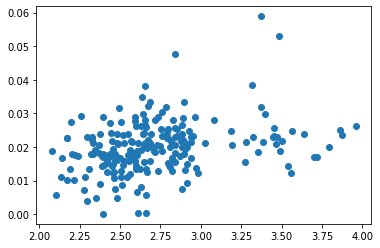

In [225]:
gene=10434
dat1 = MERFISH_CellMean_Exp.loc[gene,:]
dat2 = MERFISH_VolMean_Exp.loc[gene,:]
plt.scatter(dat1, dat2)

In [207]:
ISH_Exp = pd.read_csv("/home/jw3514/Work/ASD_Circuits/dat/allen-mouse-exp/JW_ExpMat.LogMean.0418.csv", index_col=0)

In [208]:
columns = ISH_Exp.columns.values
columns = [x.replace("_", " ") for x in columns]
ISH_Exp.columns = columns

In [209]:
ISH_Exp

,Accessory olfactory bulb,Agranular insular area dorsal part,Agranular insular area posterior part,Agranular insular area ventral part,Ansiform lobule,Anterior amygdalar area,Anterior cingulate area dorsal part,Anterior cingulate area ventral part,Anterior hypothalamic nucleus,Anterior olfactory nucleus,...,Ventral cochlear nucleus,Ventral medial nucleus of the thalamus,Ventral part of the lateral geniculate complex,Ventral posterolateral nucleus of the thalamus,Ventral posteromedial nucleus of the thalamus,Ventral posteromedial nucleus of the thalamus parvicellular part,Ventral tegmental area,Ventromedial hypothalamic nucleus,Visceral area,posteromedial visual area
2668,3.682287,2.878418,2.677806,2.710411,3.000677,2.256930,2.413446,2.268135,2.153733,2.836966,...,1.989196,1.906333,1.960055,2.199955,2.465963,1.830818,1.979135,2.299263,2.630536,2.603273
6770,1.436167,1.161862,0.723577,1.046512,0.724732,1.447246,1.390882,0.557868,0.141192,1.106851,...,0.336914,0.256555,0.603247,1.144621,1.591861,0.572919,0.345350,0.040313,0.690253,0.823324
2535,0.775212,0.580745,0.631250,0.564019,0.112074,0.131378,0.581266,0.431544,0.250064,0.220035,...,0.175744,0.164252,0.105753,0.097797,0.118175,0.242149,0.134410,0.176791,0.440751,0.403467
3207,1.987234,2.285657,1.877250,2.212314,1.299784,1.505764,2.105018,1.727411,2.228009,1.695219,...,0.530448,1.384696,0.900468,0.967827,0.664151,1.034279,1.128445,1.696092,1.610705,1.164761
3227,0.110012,0.656693,0.682998,0.490498,0.221711,0.155049,0.310955,0.280766,0.244963,0.301427,...,0.133483,0.149271,0.077675,0.181210,0.388039,0.232475,0.139376,0.209949,0.752306,0.520247
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
646698,0.988958,0.822762,0.814045,0.713589,0.700738,0.655173,0.682139,0.617511,0.500272,0.796744,...,0.512397,0.522015,0.617487,0.541264,0.543240,0.584741,0.536466,0.541348,0.703718,0.702283
90204,0.009411,0.039218,0.193508,0.022056,0.045258,1.835839,0.198738,0.145567,0.369365,0.128703,...,0.113355,0.219812,0.532211,1.768790,1.416153,0.177744,0.237129,0.528723,0.012551,0.420698
140831,0.047854,0.215235,0.000912,0.058021,0.153616,0.588984,0.058551,0.037979,0.083019,0.265019,...,0.195070,0.008837,0.228331,0.011919,0.005000,0.037684,0.024529,0.279175,0.006214,0.423222
65249,0.698443,0.632358,0.119429,0.506419,0.548539,0.155638,0.741364,0.606050,0.025590,0.494737,...,0.196496,0.032229,0.369494,0.202221,0.238078,0.074733,0.085544,0.013456,0.223916,0.551278


In [226]:
Shared_Genes = np.array(list(set(MERFISH_CellMean_Exp.index.values).intersection(set(ISH_Exp.index.values))))
Shared_STRs = np.array(list(set(MERFISH_CellMean_Exp.columns.values).intersection(set(ISH_Exp.columns.values))))

In [211]:
STR = "Frontal pole cerebral cortex"
dat1 = MERFISH_CellMean_Exp.loc[Shared_Genes, STR]
dat2 = MERFISH_VolMean_Exp.loc[Shared_Genes, STR]
dat3 = ISH_Exp.loc[Shared_Genes, STR]

SpearmanrResult(correlation=0.5361989247566153, pvalue=0.0)


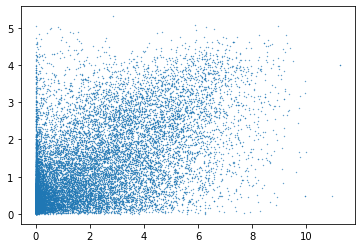

In [215]:
print(spearmanr(dat1, dat3, nan_policy="omit"))
plt.scatter(dat1, dat3, s=0.1)

SpearmanrResult(correlation=0.5361989247566153, pvalue=0.0)


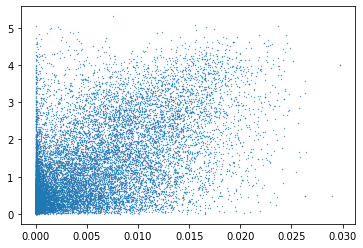

In [216]:
print(spearmanr(dat2, dat3, nan_policy="omit"))
plt.scatter(dat2, dat3, s=0.1)

In [229]:
for STR in sorted(Shared_STRs):
    dat1 = MERFISH_CellMean_Exp.loc[Shared_Genes, STR]
    dat2 = MERFISH_VolMean_Exp.loc[Shared_Genes, STR]
    dat3 = ISH_Exp.loc[Shared_Genes, STR]
    R1, P1 = spearmanr(dat2, dat3, nan_policy="omit")
    R2, P2 = spearmanr(dat2, dat3, nan_policy="omit")
    print(STR, R)

Accessory olfactory bulb 0.5646484380900821
Agranular insular area dorsal part 0.5646484380900821
Agranular insular area posterior part 0.5646484380900821
Agranular insular area ventral part 0.5646484380900821
Ansiform lobule 0.5646484380900821
Anterior amygdalar area 0.5646484380900821
Anterior cingulate area dorsal part 0.5646484380900821
Anterior cingulate area ventral part 0.5646484380900821
Anterior hypothalamic nucleus 0.5646484380900821
Anterior olfactory nucleus 0.5646484380900821
Anterior pretectal nucleus 0.5646484380900821
Anterodorsal nucleus 0.5646484380900821
Anterolateral visual area 0.5646484380900821
Anteromedial nucleus dorsal part 0.5646484380900821
Anteromedial nucleus ventral part 0.5646484380900821
Anteromedial visual area 0.5646484380900821
Anteroventral nucleus of thalamus 0.5646484380900821
Arcuate hypothalamic nucleus 0.5646484380900821
Basolateral amygdalar nucleus 0.5646484380900821
Basomedial amygdalar nucleus 0.5646484380900821
Bed nuclei of the stria term

Spinal vestibular nucleus 0.5646484380900821
Submedial nucleus of the thalamus 0.5646484380900821
Subparafascicular area 0.5646484380900821
Subparafascicular nucleus magnocellular part 0.5646484380900821
Subparafascicular nucleus parvicellular part 0.5646484380900821
Subparaventricular zone 0.5646484380900821
Substantia innominata 0.5646484380900821
Substantia nigra compact part 0.5646484380900821
Substantia nigra reticular part 0.5646484380900821
Subthalamic nucleus 0.5646484380900821
Superior central nucleus raphe 0.5646484380900821
Superior colliculus motor related 0.5646484380900821
Superior colliculus sensory related 0.5646484380900821
Superior olivary complex 0.5646484380900821
Superior vestibular nucleus 0.5646484380900821
Supplemental somatosensory area 0.5646484380900821
Supramammillary nucleus 0.5646484380900821
Supratrigeminal nucleus 0.5646484380900821
Taenia tecta 0.5646484380900821
Tegmental reticular nucleus 0.5646484380900821
Temporal association areas 0.564648438090082

In [235]:
G_corr_corss_STR_CellMean = []
G_corr_corss_STR_VolMean = []
G_corr_corss_STR_Cell_v_Vol = []
for G in Shared_Genes:
    dat1 = MERFISH_CellMean_Exp.loc[G, Shared_STRs]
    dat2 = MERFISH_VolMean_Exp.loc[G, Shared_STRs]
    dat3 = ISH_Exp.loc[G, Shared_STRs]
    R1, P1 = spearmanr(dat1, dat3, nan_policy="omit")
    R2, P2 = spearmanr(dat2, dat3, nan_policy="omit")
    R3, P3 = spearmanr(dat1, dat2, nan_policy="omit")
    G_corr_corss_STR_CellMean.append(R1)
    G_corr_corss_STR_VolMean.append(R2)
    G_corr_corss_STR_Cell_v_Vol.append(R3)
    #print(STR, R)

/home/jw3514/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/jw3514/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/jw3514/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/jw3514/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/jw3514/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4484: Sp

/home/jw3514/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/jw3514/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


Text(0.5, 0, 'SpearmanR')

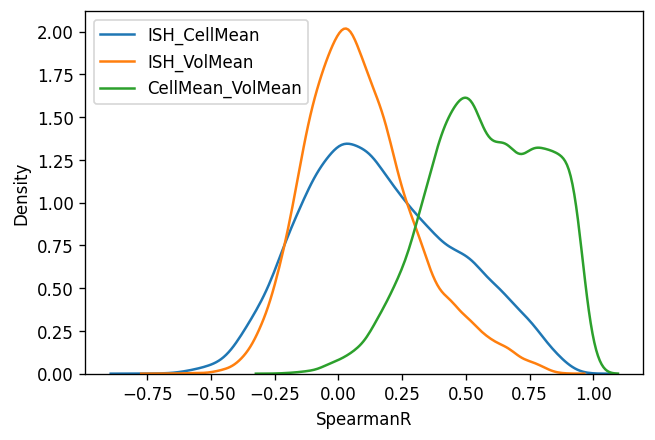

In [246]:
plt.figure(dpi=120)
sns.kdeplot(G_corr_corss_STR_CellMean, label="ISH_CellMean")
sns.kdeplot(G_corr_corss_STR_VolMean, label="ISH_VolMean")
sns.kdeplot(G_corr_corss_STR_Cell_v_Vol, label="CellMean_VolMean")
plt.legend()
plt.xlabel("SpearmanR")

In [250]:
GeneCorrDF = pd.DataFrame(data={"Gene":Shared_Genes, "ISH_CellMean":G_corr_corss_STR_CellMean,
                               "ISH_VolMean":G_corr_corss_STR_VolMean,
                               "Cellmean_VolMean":G_corr_corss_STR_Cell_v_Vol})
GeneCorrDF = GeneCorrDF.set_index("Gene")

In [252]:
GeneCorrDF.head(5)

,ISH_CellMean,ISH_VolMean,Cellmean_VolMean
Gene,,,
1,0.193173,0.135497,0.790475
2,0.498521,0.413728,0.869470
131076,-0.049721,-0.234621,0.356359
9,-0.102164,-0.154933,0.637063
10,-0.102164,-0.154933,0.637063


Text(0, 0.5, 'vol mean')

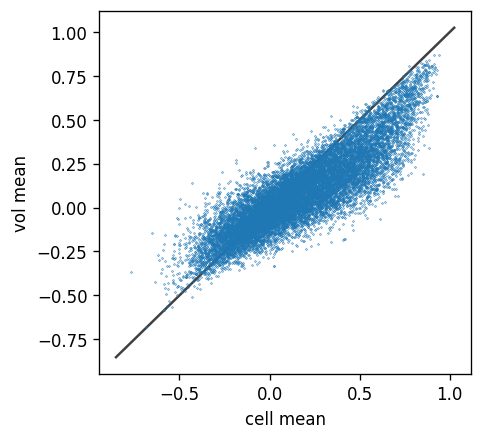

In [265]:
#plt.scatter(GeneCorrDF["ISH_CellMean"].values, GeneCorrDF["ISH_VolMean"].values, s=0.1)
fig, ax = plt.subplots(figsize=(4,4), dpi=120)
ax.scatter(GeneCorrDF["ISH_CellMean"].values, GeneCorrDF["ISH_VolMean"].values, s=0.1)

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
plt.xlabel("cell mean")
plt.ylabel("vol mean")

# ASD Z2 Bias with MERFISH

In [186]:
MERFISH_Exp_Cell = pd.read_csv("/home/jw3514/Work/CellType_Psy/AllenBrainCellAtlas/dat/MERFISH/STR_Cell_Mean_DF.csv",index_col=0)
MERFISH_Exp_Vol = pd.read_csv("/home/jw3514/Work/CellType_Psy/AllenBrainCellAtlas/dat/MERFISH/STR_Vol_Mean_DF.csv", index_col=0)

MERFISH_Z1_Cell = pd.read_csv("/home/jw3514/Work/CellType_Psy/AllenBrainCellAtlas/dat/MERFISH/STR_Cell_Mean_DF.Z1.csv",index_col=0)
MERFISH_Z1_Vol = pd.read_csv("/home/jw3514/Work/CellType_Psy/AllenBrainCellAtlas/dat/MERFISH/STR_Vol_Mean_DF.Z1.csv", index_col=0)

MERFISH_Z2_Cell = pd.read_csv("/home/jw3514/Work/CellType_Psy/AllenBrainCellAtlas/dat/MERFISH/SC_STR_CellMean.Z2.csv",index_col=0)
MERFISH_Z2_Vol = pd.read_csv("/home/jw3514/Work/CellType_Psy/AllenBrainCellAtlas/dat/MERFISH/SC_STR_VolMean.Z2.csv", index_col=0)
MERFISH_Z2_Cell2 = pd.read_csv("/home/jw3514/Work/CellType_Psy/AllenBrainCellAtlas/dat/MERFISH/SC_STR_CellMean.ISH.Match.Z2.csv", index_col=0)

In [187]:
### Fix header
head = MERFISH_Z2_Cell.columns.values
new_head = [X.replace(" ", "_") for X in head]
MERFISH_Exp_Cell.columns = new_head
MERFISH_Exp_Vol.columns = new_head
MERFISH_Z1_Cell.columns = new_head
MERFISH_Z1_Vol.columns = new_head
MERFISH_Z2_Cell.columns = new_head
MERFISH_Z2_Vol.columns = new_head
MERFISH_Z2_Cell2.columns = new_head

In [188]:
MERFISH_Z2_Cell.to_csv("/home/jw3514/Work/CellType_Psy/AllenBrainCellAtlas/dat/MERFISH/SC_STR_CellMean.Z2.nh.csv")

In [542]:
ASD_GW = Fil2Dict("../../ASD_Circuits/dat/Unionize_bias/Spark_Meta_EWS.GeneWeight.csv")
del ASD_GW[23126]

In [543]:
# ASD Genes
ASD_Bias_MERFISH_Exp_Cell = AvgSTRZ_Weighted(MERFISH_Exp_Cell, ASD_GW)
ASD_Bias_MERFISH_Exp_Vol = AvgSTRZ_Weighted(MERFISH_Exp_Vol, ASD_GW)

ASD_Bias_MERFISH_Z1_Cell = AvgSTRZ_Weighted(MERFISH_Z1_Cell, ASD_GW)
ASD_Bias_MERFISH_Z1_Vol = AvgSTRZ_Weighted(MERFISH_Z1_Vol, ASD_GW)

ASD_Bias_MERFISH_Z2_Cell = AvgSTRZ_Weighted(MERFISH_Z2_Cell, ASD_GW)
ASD_Bias_MERFISH_Z2_Vol = AvgSTRZ_Weighted(MERFISH_Z2_Vol, ASD_GW)
ASD_Bias_MERFISH_Z2_Cell2 = AvgSTRZ_Weighted(MERFISH_Z2_Cell2, ASD_GW)

In [544]:
#print(RegionDistributionsList(ASD_Bias_MERFISH_Z2_Cell.head(50).index.values))
#print(RegionDistributionsList(ASD_Bias_MERFISH_Z2_Vol.head(50).index.values))

In [545]:
ASD_STR_ISH_Bias = pd.read_csv("/home/jw3514/Work/ASD_Circuits/dat/Unionize_bias/Spark_Meta_EWS.Z2.bias.FDR.csv", 
                               index_col=0)
#ASD_STR_ISH_Bias.loc["Subiculum_dorsal_part"]
#ASD_STR_ISH_Bias.loc["Subiculum_ventral_part"]
ASD_STR_ISH_Bias.loc["Subiculum"] = [(0.257096+0.385119)/2, "Hippocampus", 214, 1, 0, 1]
ASD_STR_ISH_Bias = ASD_STR_ISH_Bias.drop(["Subiculum_dorsal_part", "Subiculum_ventral_part"])

In [546]:
ASD_Bias_MERFISH_Z2_Cell.head(50)

,EFFECT,REGION,Rank
STR,,,
Main_olfactory_bulb,0.629272,Olfactory_areas,1
Olfactory_tubercle,0.514145,Striatum,2
Intercalated_amygdalar_nucleus,0.496814,Amygdala,3
Central_lobule,0.468420,Cerebellum,4
Culmen,0.450593,Cerebellum,5
Subparaventricular_zone,0.445709,Hypothalamus,6
Dorsomedial_nucleus_of_the_hypothalamus,0.439140,Hypothalamus,7
Simple_lobule,0.434898,Cerebellum,8
Nucleus_accumbens,0.434166,Striatum,9


In [547]:
ASD_Bias_MERFISH_Z2_Cell2.head(50)

,EFFECT,REGION,Rank
STR,,,
Intercalated_amygdalar_nucleus,0.796069,Amygdala,1
Main_olfactory_bulb,0.773472,Olfactory_areas,2
Olfactory_tubercle,0.744944,Striatum,3
Bed_nuclei_of_the_stria_terminalis,0.708941,Pallidum,4
Subparaventricular_zone,0.692763,Hypothalamus,5
Nucleus_accumbens,0.686511,Striatum,6
Medial_pretectal_area,0.612019,Midbrain,7
Primary_visual_area,0.578065,Isocortex,8
Dorsomedial_nucleus_of_the_hypothalamus,0.577237,Hypothalamus,9


In [548]:
# ASD_STR_ISH_Bias
# ASD_Bias_MERFISH_Z2_Cell
# ASD_Bias_MERFISH_Z2_Vol

(0.7257621510255597, 5.808612261998666e-36)


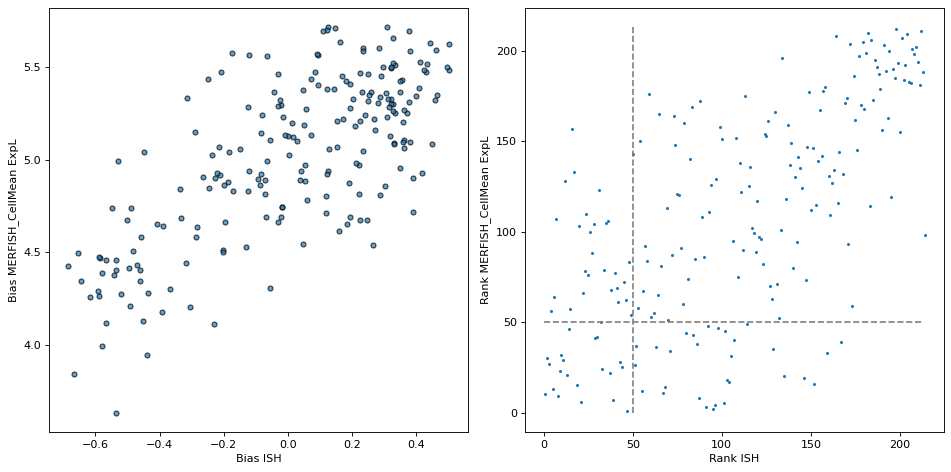

In [549]:
BiasCorrelation(ASD_STR_ISH_Bias, ASD_Bias_MERFISH_Exp_Cell, "ISH", "MERFISH_CellMean ExpL")

(0.6410290311152015, 6.29482397427343e-26)


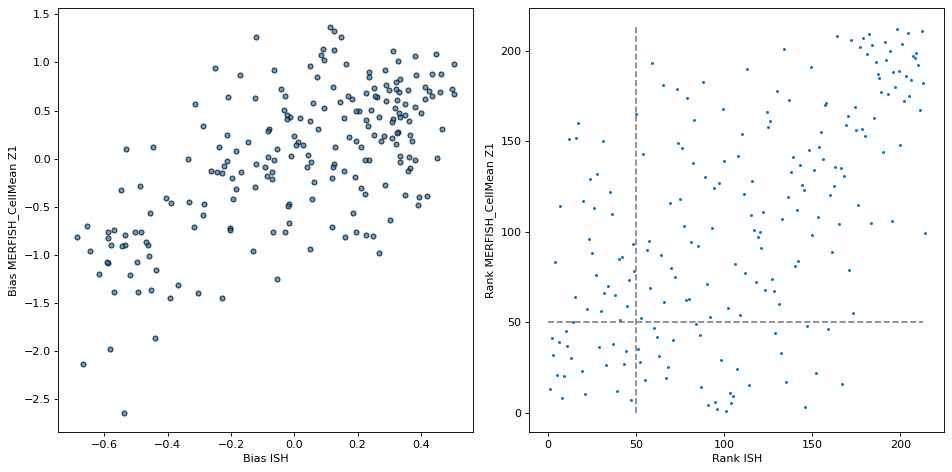

In [550]:
BiasCorrelation(ASD_STR_ISH_Bias, ASD_Bias_MERFISH_Z1_Cell, "ISH", "MERFISH_CellMean Z1")

(0.4297868461725924, 6.107146567910567e-11)


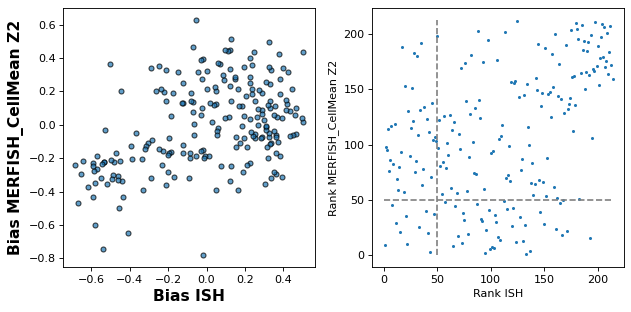

In [553]:
BiasCorrelation(ASD_STR_ISH_Bias, ASD_Bias_MERFISH_Z2_Cell, "ISH", "MERFISH_CellMean Z2")

[[1.         0.56156635]
 [0.56156635 1.        ]]


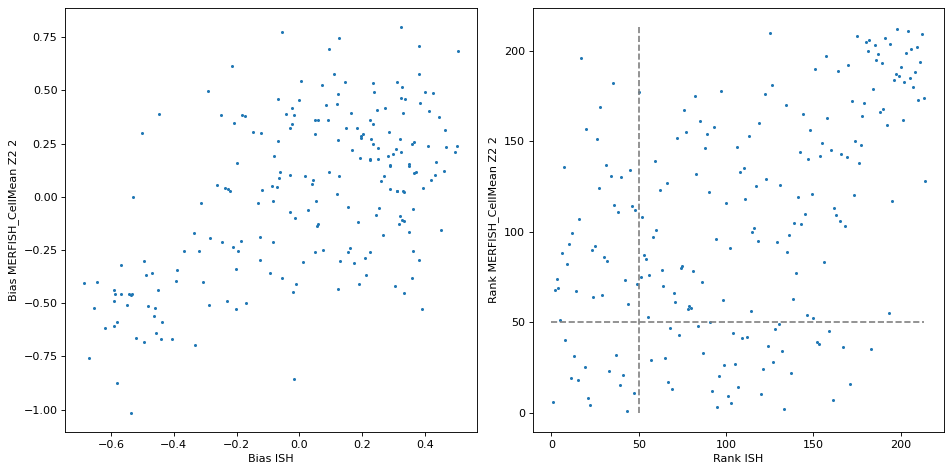

In [185]:
BiasCorrelation(ASD_STR_ISH_Bias, ASD_Bias_MERFISH_Z2_Cell2, "ISH", "MERFISH_CellMean Z2 2")

[[1.         0.33122951]
 [0.33122951 1.        ]]


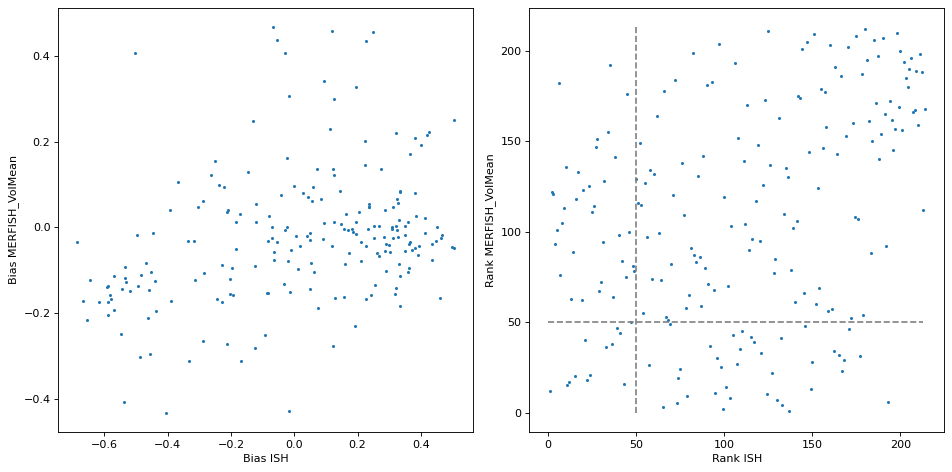

In [117]:
BiasCorrelation(ASD_STR_ISH_Bias, ASD_Bias_MERFISH_Z2_Vol, "ISH", "MERFISH_VolMean")

[[1.         0.85369288]
 [0.85369288 1.        ]]


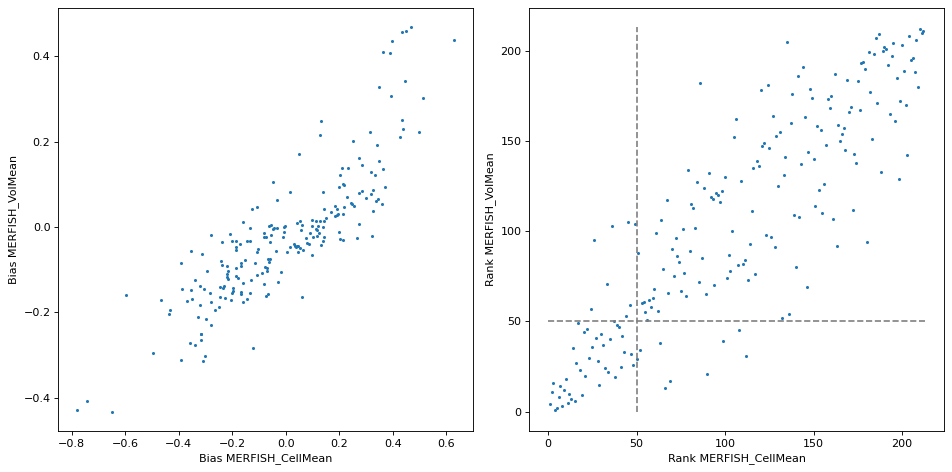

In [118]:
BiasCorrelation(ASD_Bias_MERFISH_Z2_Cell, ASD_Bias_MERFISH_Z2_Vol, "MERFISH_CellMean", "MERFISH_VolMean")

[[1.         0.57219365]
 [0.57219365 1.        ]]


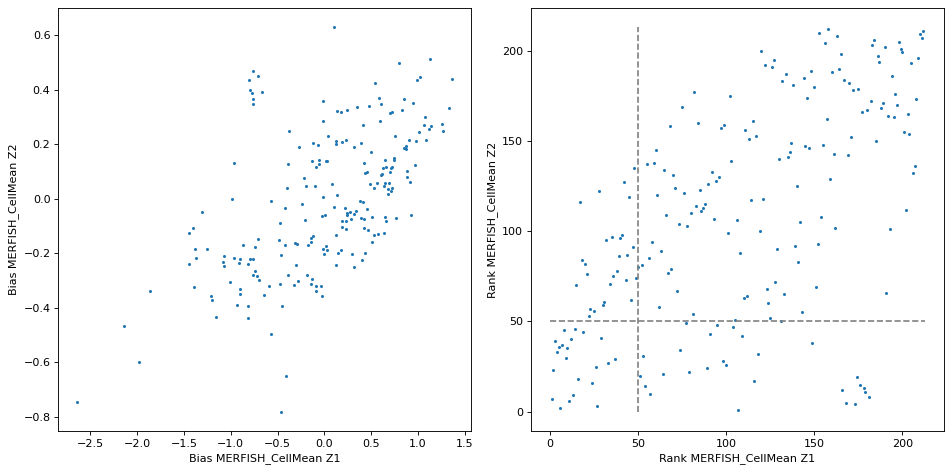

In [140]:
BiasCorrelation(ASD_Bias_MERFISH_Z1_Cell, ASD_Bias_MERFISH_Z2_Cell, "MERFISH_CellMean Z1", "MERFISH_CellMean Z2")

In [152]:
ASD_Bias_MERFISH_Z1_Cell.head(50)

,EFFECT,REGION,Rank
STR,,,
Dorsomedial_nucleus_of_the_hypothalamus,1.366473,Hypothalamus,1
Medial_preoptic_nucleus,1.327879,Hypothalamus,2
Arcuate_hypothalamic_nucleus,1.267471,Hypothalamus,3
Posterior_amygdalar_nucleus,1.260767,Amygdalar,4
Ventromedial_hypothalamic_nucleus,1.141309,Hypothalamus,5
Olfactory_tubercle,1.131374,Striatum,6
posteromedial_visual_area,1.115982,Isocortex,7
Claustrum,1.085058,Cortical_subplate,8
Dorsal_premammillary_nucleus,1.077962,Hypothalamus,9


In [120]:
ASD_Bias_MERFISH_Exp_Cell[ASD_Bias_MERFISH_Exp_Cell["REGION"]=="Isocortex"]

,EFFECT,REGION,Rank
STR,,,
posteromedial_visual_area,5.716709,Isocortex,1
Primary_visual_area,5.693957,Isocortex,6
Lateral_visual_area,5.656460,Isocortex,7
Temporal_association_areas,5.638592,Isocortex,8
Anterolateral_visual_area,5.606108,Isocortex,11
Anterior_cingulate_area_ventral_part,5.605309,Isocortex,12
Orbital_area_ventrolateral_part,5.592199,Isocortex,13
Posterolateral_visual_area,5.587899,Isocortex,14
Retrosplenial_area_lateral_agranular_part,5.587663,Isocortex,15


In [153]:
ASD_Bias_MERFISH_Z1_Cell[ASD_Bias_MERFISH_Z1_Cell["REGION"]=="Hippocampus"]

,EFFECT,REGION,Rank
STR,,,
Postsubiculum,0.590567,Hippocampus,53
Presubiculum,0.493081,Hippocampus,62
Entorhinal_area_lateral_part,0.225673,Hippocampus,92
Entorhinal_area_medial_part_dorsal_zone,0.175939,Hippocampus,97
Subiculum,0.149827,Hippocampus,99
Field_CA3,0.014039,Hippocampus,113
Field_CA1,-0.017910,Hippocampus,117
Parasubiculum,-0.032346,Hippocampus,122
Dentate_gyrus,-0.387615,Hippocampus,151


In [138]:
ASD_Bias_MERFISH_Z2_Cell[ASD_Bias_MERFISH_Z2_Cell["REGION"]=="Hippocampus"]

,EFFECT,REGION,Rank
STR,,,
Postsubiculum,0.286387,Hippocampus,31
Presubiculum,0.170263,Hippocampus,58
Dentate_gyrus,0.126341,Hippocampus,69
Entorhinal_area_lateral_part,-0.109298,Hippocampus,133
Field_CA3,-0.171943,Hippocampus,151
Field_CA1,-0.184576,Hippocampus,153
Entorhinal_area_medial_part_dorsal_zone,-0.186389,Hippocampus,157
Subiculum,-0.199224,Hippocampus,159
Field_CA2,-0.313231,Hippocampus,188


In [122]:
ISH_Exp = pd.read_csv("/home/jw3514/Work/ASD_Circuits/dat/allen-mouse-exp/JW_ExpMat.LogMean.0418.csv", index_col=0)

In [123]:
ASD_ISH_ExpL = AvgSTRZ_Weighted(ISH_Exp, ASD_GW) 

In [124]:
X = ASD_ISH_ExpL.loc["Subiculum_dorsal_part"]
Y = ASD_ISH_ExpL.loc["Subiculum_ventral_part"]
Z = [(X[0]+Y[0])/2, "Hippocampus", 214]
ASD_ISH_ExpL.loc["Subiculum"] = Z
ASD_ISH_ExpL = ASD_ISH_ExpL.drop(["Subiculum_dorsal_part", "Subiculum_ventral_part"])

[[1.         0.60867978]
 [0.60867978 1.        ]]


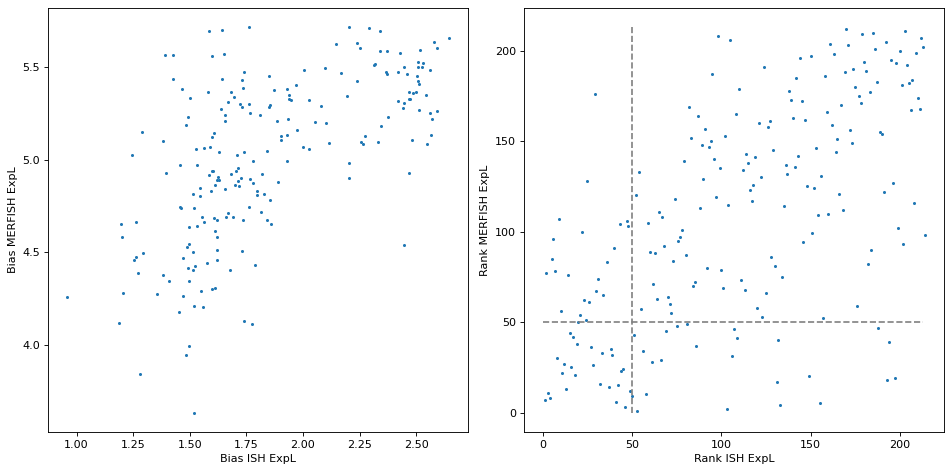

In [125]:
BiasCorrelation(ASD_ISH_ExpL, ASD_Bias_MERFISH_Exp_Cell, "ISH ExpL", "MERFISH ExpL")

[[1.         0.72576215]
 [0.72576215 1.        ]]


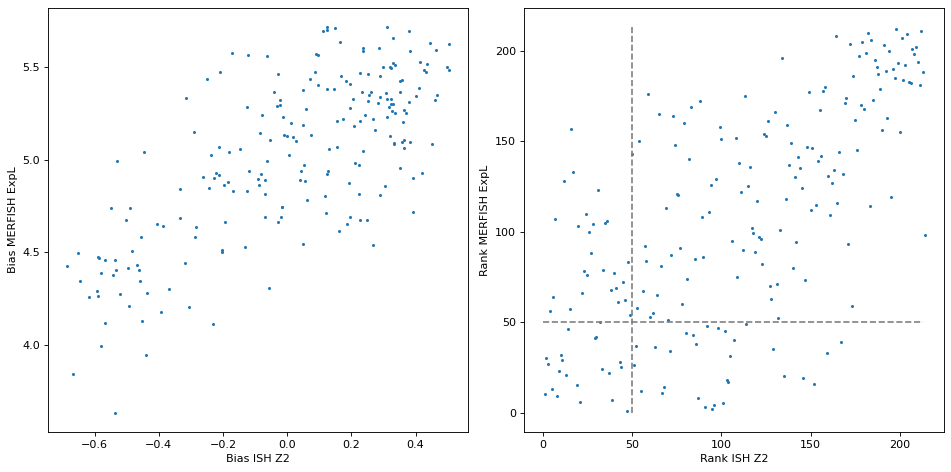

In [126]:
BiasCorrelation(ASD_STR_ISH_Bias, ASD_Bias_MERFISH_Exp_Cell, "ISH Z2", "MERFISH ExpL")

In [127]:
23126 in ASD_GW

False

In [128]:
23126 in MERFISH_Exp_Cell.index.values

True

In [129]:
MERFISH_Exp_Cell.loc[23126, :]

Frontal_pole_cerebral_cortex               3.477339
Primary_motor_area                         3.213100
Secondary_motor_area                       3.277612
Primary_somatosensory_area_nose            3.216598
Primary_somatosensory_area_barrel_field    3.267824
                                             ...   
Paraflocculus                              2.868180
Flocculus                                  2.807735
Fastigial_nucleus                          2.565020
Interposed_nucleus                         2.585035
Dentate_nucleus                            2.632793
Name: 23126, Length: 212, dtype: float64

In [141]:
ISH_Z1 = pd.read_csv("/home/jw3514/Work/ASD_Circuits/dat/allen-mouse-exp/AllenMouse_z1_mat.0511.csv", index_col=0)
ISH_Z2 = pd.read_csv("/home/jw3514/Work/ASD_Circuits/dat/allen-mouse-exp/AllenMouseBrain_Z2bias.csv", index_col=0)

In [131]:
ASD_ISH_Z1 = AvgSTRZ_Weighted(ISH_Z1, ASD_GW) 
X = ASD_ISH_Z1.loc["Subiculum_dorsal_part"]
Y = ASD_ISH_Z1.loc["Subiculum_ventral_part"]
Z = [(X[0]+Y[0])/2, "Hippocampus", 214]
ASD_ISH_Z1.loc["Subiculum"] = Z
ASD_ISH_Z1 = ASD_ISH_Z1.drop(["Subiculum_dorsal_part", "Subiculum_ventral_part"])

In [142]:
ASD_ISH_Z2 = AvgSTRZ_Weighted(ISH_Z2, ASD_GW) 
X = ASD_ISH_Z2.loc["Subiculum_dorsal_part"]
Y = ASD_ISH_Z2.loc["Subiculum_ventral_part"]
Z = [(X[0]+Y[0])/2, "Hippocampus", 214]
ASD_ISH_Z2.loc["Subiculum"] = Z
ASD_ISH_Z2 = ASD_ISH_Z2.drop(["Subiculum_dorsal_part", "Subiculum_ventral_part"])

[[1.        0.6154985]
 [0.6154985 1.       ]]


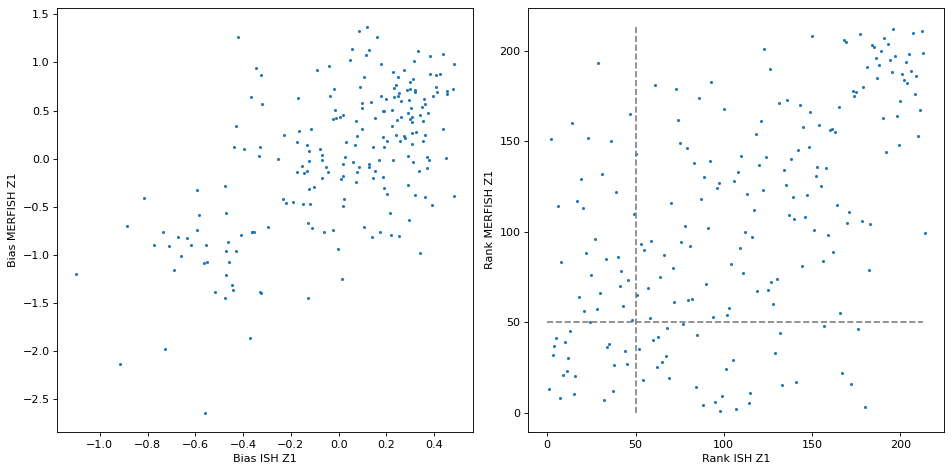

In [134]:
BiasCorrelation(ASD_ISH_Z1, ASD_Bias_MERFISH_Z1_Cell, "ISH Z1", "MERFISH Z1")

[[1.        0.9597086]
 [0.9597086 1.       ]]


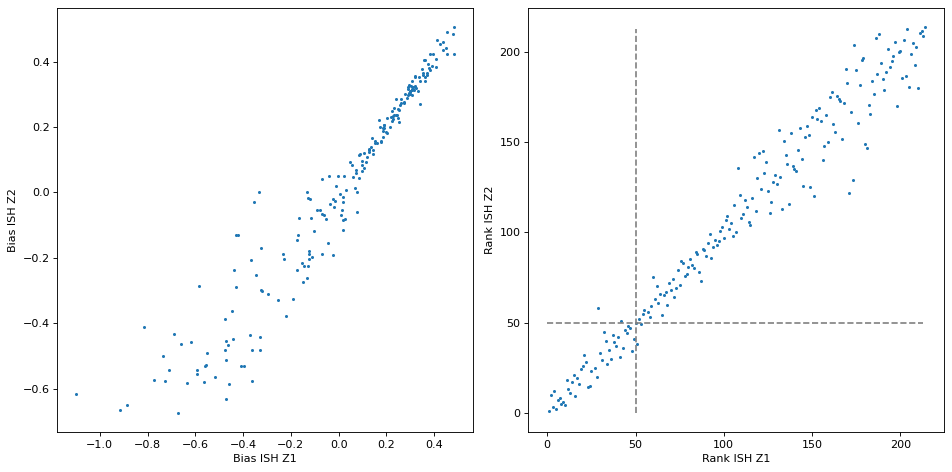

In [143]:
BiasCorrelation(ASD_ISH_Z1, ASD_ISH_Z2, "ISH Z1", "ISH Z2")

[[1.         0.72209996]
 [0.72209996 1.        ]]


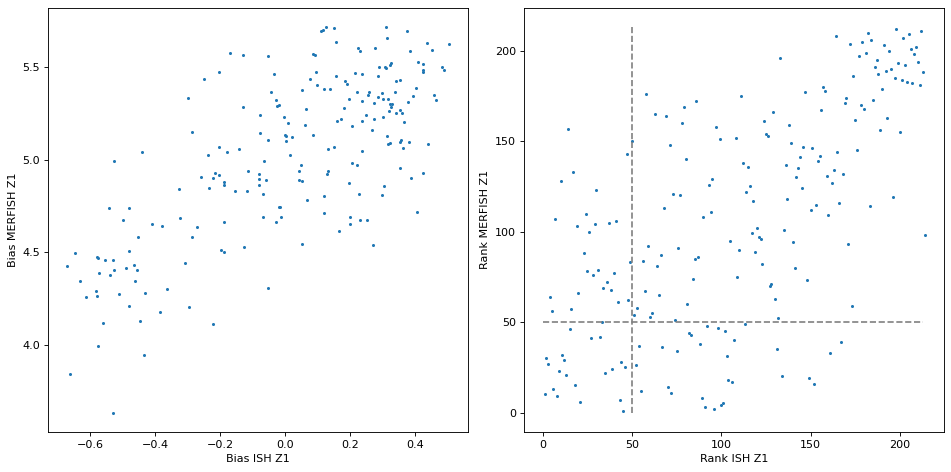

In [145]:
BiasCorrelation(ASD_ISH_Z2, ASD_Bias_MERFISH_Exp_Cell, "ISH Z1", "MERFISH Z1")

[[1.         0.63830942]
 [0.63830942 1.        ]]


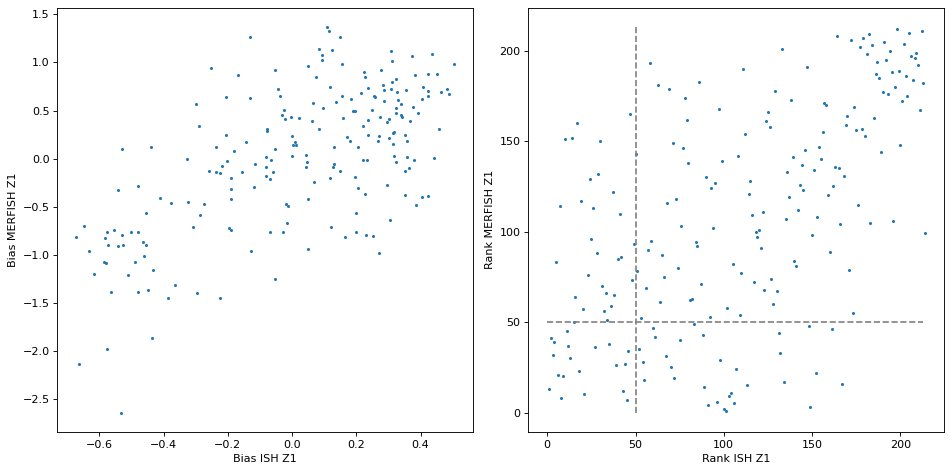

In [144]:
BiasCorrelation(ASD_ISH_Z2, ASD_Bias_MERFISH_Z1_Cell, "ISH Z1", "MERFISH Z1")

[[1.         0.42929084]
 [0.42929084 1.        ]]


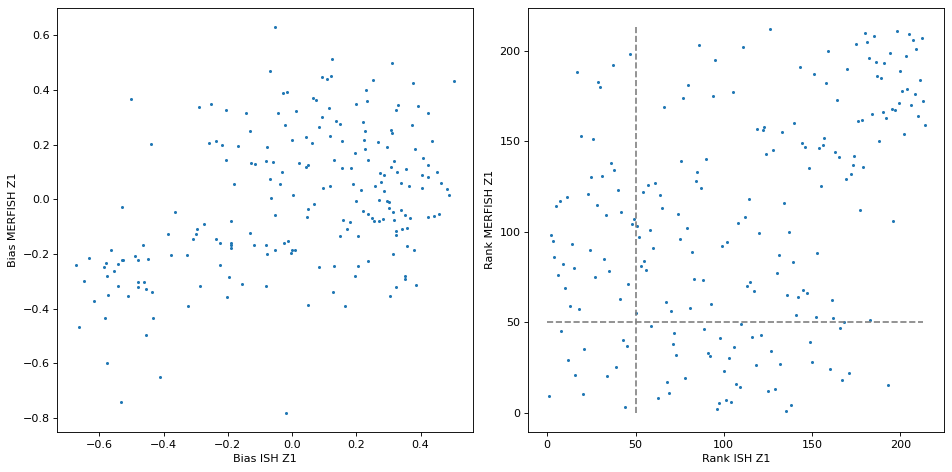

In [146]:
BiasCorrelation(ASD_ISH_Z2, ASD_Bias_MERFISH_Z2_Cell, "ISH Z1", "MERFISH Z1")

In [148]:
ASD_ISH_Z2[ASD_ISH_Z2["REGION"]=="Hypothalamus"]

,EFFECT,REGION,Rank
STR,,,
Lateral_preoptic_area,0.131325,Hypothalamus,93
Paraventricular_hypothalamic_nucleus,0.118960,Hypothalamus,98
Medial_preoptic_nucleus,0.115986,Hypothalamus,100
Dorsomedial_nucleus_of_the_hypothalamus,0.109029,Hypothalamus,101
Dorsal_premammillary_nucleus,0.093897,Hypothalamus,103
Subparaventricular_zone,0.092310,Hypothalamus,104
Ventromedial_hypothalamic_nucleus,0.083804,Hypothalamus,106
Anterior_hypothalamic_nucleus,0.075310,Hypothalamus,107
Posterior_hypothalamic_nucleus,0.064336,Hypothalamus,109


In [149]:
ASD_ISH_Z1[ASD_ISH_Z1["REGION"]=="Hypothalamus"]

,EFFECT,REGION,Rank
STR,,,
Lateral_preoptic_area,0.127734,Hypothalamus,96
Dorsomedial_nucleus_of_the_hypothalamus,0.118688,Hypothalamus,98
Dorsal_premammillary_nucleus,0.115375,Hypothalamus,99
Anterior_hypothalamic_nucleus,0.106569,Hypothalamus,101
Posterior_hypothalamic_nucleus,0.098553,Hypothalamus,102
Paraventricular_hypothalamic_nucleus,0.090833,Hypothalamus,105
Lateral_hypothalamic_area,0.087363,Hypothalamus,106
Medial_preoptic_nucleus,0.086677,Hypothalamus,107
Ventromedial_hypothalamic_nucleus,0.055620,Hypothalamus,114


In [155]:
# QN Z1
QN_Z1 = quantileNormalize(MERFISH_Z1_Cell)

In [157]:
ASD_MERFISH_Z1QN_Cell = AvgSTRZ_Weighted(QN_Z1, ASD_GW)

[[1.         0.66152154]
 [0.66152154 1.        ]]


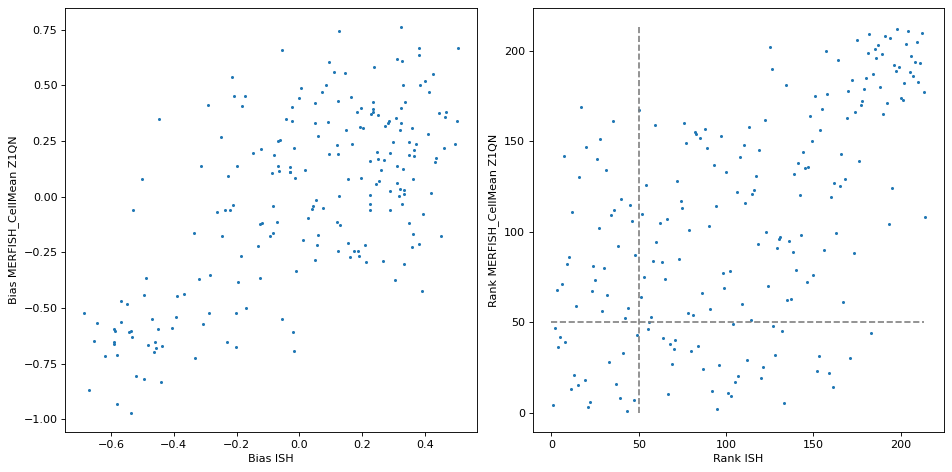

In [159]:
BiasCorrelation(ASD_STR_ISH_Bias, ASD_MERFISH_Z1QN_Cell, "ISH", "MERFISH_CellMean Z1QN")

###### QN expl then Z1

In [162]:
def Z1Conversion(ExpMat, outname="test.z1.mat"):
    Z_mat = []
    for g, row in ExpMat.iterrows():
        tmp = ZscoreConverting(row.values)
        Z_mat.append(tmp)
    Z_mat = np.array(Z_mat)
    CT_Z1_DF = pd.DataFrame(data=Z_mat, index=ExpMat.index.values, 
                            columns=ExpMat.columns.values)
    CT_Z1_DF.to_csv(outname)
    return CT_Z1_DF

In [163]:
QN_ExpL = quantileNormalize(MERFISH_Exp_Cell)
QN_Z1 = Z1Conversion(QN_ExpL)

/home/jw3514/Work/CellType_Psy/src/ASD_Circuits.py:70: RuntimeWarning: invalid value encountered in double_scalars
  z = (x - mean)/std


In [164]:
ASD_MERFISH_Z1QN_Cell = AvgSTRZ_Weighted(QN_Z1, ASD_GW)

[[1.         0.00705231]
 [0.00705231 1.        ]]


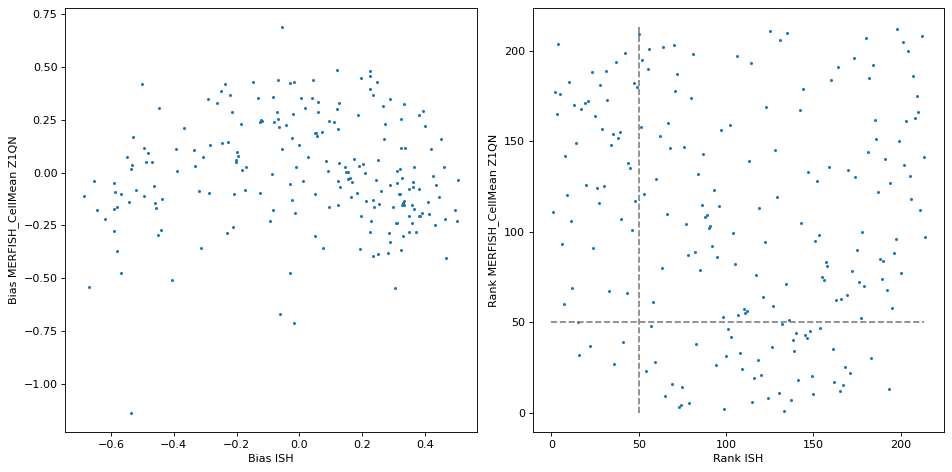

In [165]:
BiasCorrelation(ASD_STR_ISH_Bias, ASD_MERFISH_Z1QN_Cell, "ISH", "MERFISH_CellMean Z1QN")

## Sibling

In [217]:
Dir1 = "/home/jw3514/Work/ASD_Circuits/dat/CTRL/SubSampleSib_w_GeneProb/ISH_STR"
Dir2 = "/home/jw3514/Work/ASD_Circuits/dat/CTRL/SubSampleSib_w_GeneProb/MERFISH_STR"
Sib_PearsonRs = []
Sib_SpearmanRs = []
Sib_top50_bias_ISH = []
Sib_top50_bias_Merfish = []
for i in range(1000):
    Pair1 = pd.read_csv("{}/cont.bias.{}.csv".format(Dir1, i), index_col=0)
    Pair2 = pd.read_csv("{}/cont.bias.{}.csv".format(Dir2, i), index_col=0)
    Sib_top50_bias_ISH.append(Pair1.head(50)["EFFECT"].mean())
    Sib_top50_bias_Merfish.append(Pair2.head(50)["EFFECT"].mean())
    r1, r2 = GetBiasCorrelation_STR(Pair1, Pair2)
    Sib_PearsonRs.append(r1)
    Sib_SpearmanRs.append(r2)

In [223]:
asd_r1, asd_r2 = GetBiasCorrelation_STR(ASD_ISH_Z2, ASD_Bias_MERFISH_Z2_Cell)
asd_top50 = ASD_ISH_Z2.head(50)["EFFECT"].mean()

(0.36081222502978, 4.1308021795544085e-32)


Text(0, 0.5, 'Mean top50 Bias')

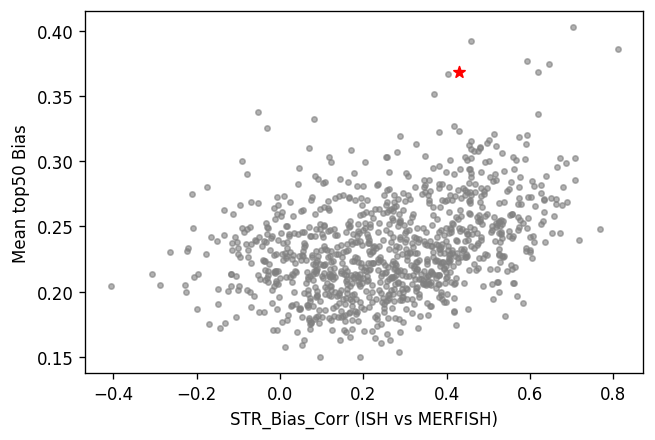

In [232]:
# Correlation vs Bias level
plt.figure(dpi=120, figsize=(6,4))
print(pearsonr(Sib_PearsonRs, Sib_top50_bias_ISH))
plt.scatter(Sib_PearsonRs, Sib_top50_bias_ISH, s=10, color="grey", label="siblings", alpha=0.6)
plt.scatter(asd_r1, asd_top50, color='r', marker="*", s=50, label="ASD")
plt.xlabel("STR_Bias_Corr (ISH vs MERFISH)")
plt.ylabel("Mean top50 Bias")

In [521]:
##### Is hypothalamus over-represent in MERFISH?
Dir1 = "/home/jw3514/Work/ASD_Circuits/dat/CTRL/SubSampleSib_w_GeneProb/ISH_STR"
Dir2 = "/home/jw3514/Work/ASD_Circuits/dat/CTRL/SubSampleSib_w_GeneProb/MERFISH_STR"
Sib_Isocortex_ISH = []
Sib_Isocortex_Merfish = []
Sib_Hypothalamus_ISH = []
Sib_Hypothalamus_Merfish = []
for i in range(1000):
    Pair1 = pd.read_csv("{}/cont.bias.{}.csv".format(Dir1, i), index_col=0)
    Pair2 = pd.read_csv("{}/cont.bias.{}.csv".format(Dir2, i), index_col=0)
    Sib_Isocortex_ISH.append(Pair1[Pair1["REGION"]=="Isocortex"]["EFFECT"].mean())
    Sib_Isocortex_Merfish.append(Pair2[Pair2["REGION"]=="Isocortex"]["EFFECT"].mean())
    Sib_Hypothalamus_ISH.append(Pair1[Pair1["REGION"]=="Hypothalamus"]["EFFECT"].mean())
    Sib_Hypothalamus_Merfish.append(Pair2[Pair2["REGION"]=="Hypothalamus"]["EFFECT"].mean())

Text(0.5, 1.0, 'SubSampledSib')

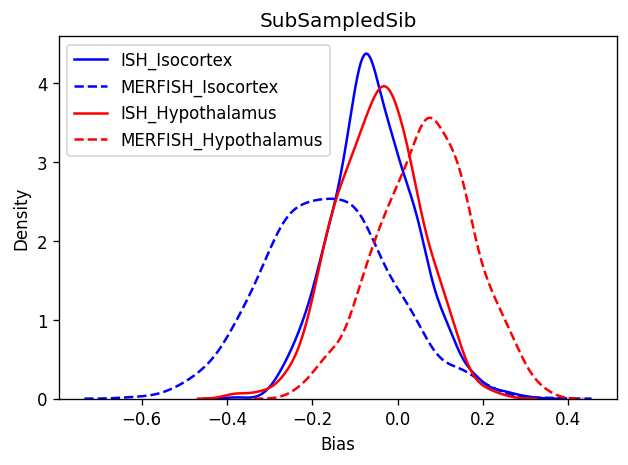

In [522]:
plt.figure(dpi=120)
sns.kdeplot(Sib_Isocortex_ISH, label="ISH_Isocortex", color="blue")
sns.kdeplot(Sib_Isocortex_Merfish, label="MERFISH_Isocortex", color="blue", ls="--")
sns.kdeplot(Sib_Hypothalamus_ISH, label="ISH_Hypothalamus", color="red")
sns.kdeplot(Sib_Hypothalamus_Merfish, label="MERFISH_Hypothalamus", color="red", ls="--")
plt.legend()
plt.xlabel("Bias")
plt.title("SubSampledSib")

In [530]:
Dir1 = "/home/jw3514/Work/CellType_Psy/dat/CTRL/SubSampleSib_w_GeneProb"
Sib_Isocortex = []
Sib_Hypothalamus = []
for i in range(1000):
    Pair1 = pd.read_csv("{}/cont.bias.{}.csv".format(Dir1, i), index_col=0)
    Sib_Isocortex.append(Pair1[Pair1["Supercluster"]=="Deep-layer intratelencephalic"]["EFFECT"].mean())
    Sib_Hypothalamus.append(Pair1[Pair1["Supercluster"]=="Mammillary body"]["EFFECT"].mean())

In [531]:
ASD_CT_Bias = pd.read_csv("test.csv", index_col=0)

In [532]:
##### Is hypothalamus CT over-represent in Siblings?
HY_GABA = ASD_CT_Bias[ASD_CT_Bias["class_id_label"]=="12 HY GABA"].index.values
IT_ET = ASD_CT_Bias[ASD_CT_Bias["class_id_label"]=="01 IT-ET Glut"].index.values
Dir = "/home/jw3514/Work/CellType_Psy/AllenBrainCellAtlas/dat/CTRL/SubSampleSib_w_GeneProb/Cluster_V3"
Sib_Isocortex2 = []
Sib_Hypothalamus2 = []
for i in range(1000):
    SibDF = pd.read_csv("{}/cont.bias.{}.csv".format(Dir, i), index_col=0)
    Sib_Isocortex2.append(SibDF.loc[IT_ET, "EFFECT"].mean())
    Sib_Hypothalamus2.append(SibDF.loc[HY_GABA, "EFFECT"].mean())

Text(0.5, 1.0, 'SubSampledSib')

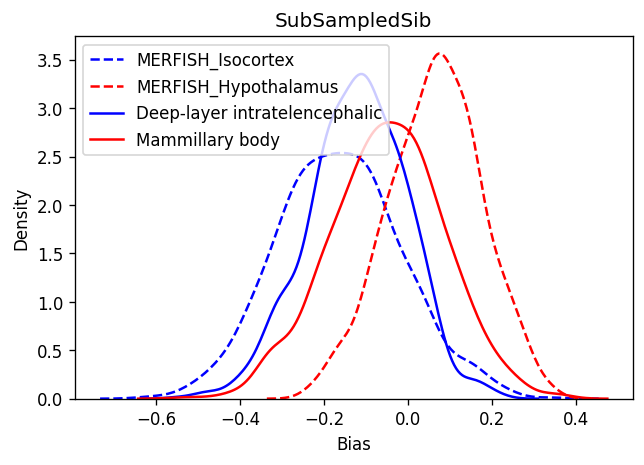

In [534]:
plt.figure(dpi=120)
#sns.kdeplot(Sib_Isocortex_ISH, label="ISH_Isocortex", color="blue")
sns.kdeplot(Sib_Isocortex_Merfish, label="MERFISH_Isocortex", color="blue", ls="--")
#sns.kdeplot(Sib_Hypothalamus_ISH, label="ISH_Hypothalamus", color="red")
sns.kdeplot(Sib_Hypothalamus_Merfish, label="MERFISH_Hypothalamus", color="red", ls="--")

sns.kdeplot(Sib_Isocortex, label="Deep-layer intratelencephalic", color="blue")
sns.kdeplot(Sib_Hypothalamus, label="Mammillary body", color="red",)

#sns.kdeplot(Sib_Isocortex2, label="IT-ET", color="blue", ls="..")
#sns.kdeplot(Sib_Hypothalamus2, label="HY_GABA", color="red", ls='..')

plt.legend()
plt.xlabel("Bias")
plt.title("SubSampledSib")

Text(0.5, 1.0, 'SubSampledSib')

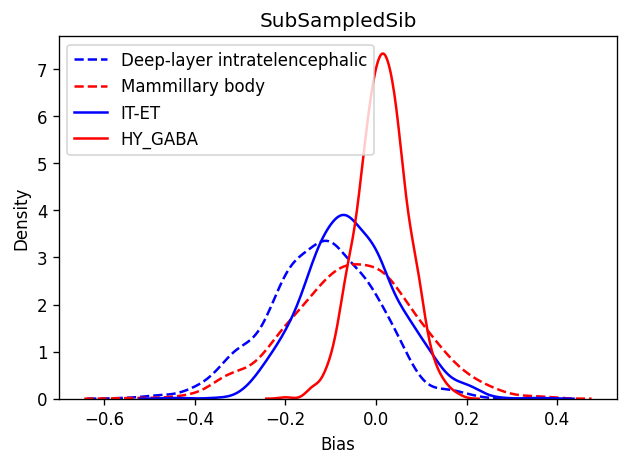

In [540]:
plt.figure(dpi=120)

sns.kdeplot(Sib_Isocortex, label="Deep-layer intratelencephalic", color="blue", ls="--")
sns.kdeplot(Sib_Hypothalamus, label="Mammillary body", color="red", ls="--")

sns.kdeplot(Sib_Isocortex2, label="IT-ET", color="blue", )
sns.kdeplot(Sib_Hypothalamus2, label="HY_GABA", color="red", )

plt.legend()
plt.xlabel("Bias")
plt.title("SubSampledSib")

Text(0.5, 1.0, 'SubSampledSib')

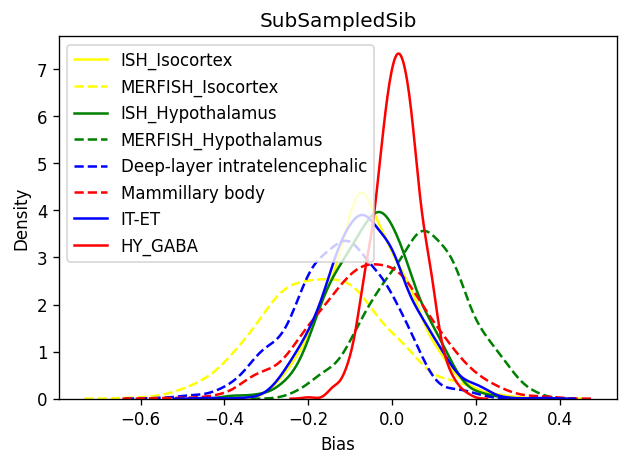

In [539]:
plt.figure(dpi=120)

sns.kdeplot(Sib_Isocortex_ISH, label="ISH_Isocortex", color="yellow")
sns.kdeplot(Sib_Isocortex_Merfish, label="MERFISH_Isocortex", color="yellow", ls="--")
sns.kdeplot(Sib_Hypothalamus_ISH, label="ISH_Hypothalamus", color="green", )
sns.kdeplot(Sib_Hypothalamus_Merfish, label="MERFISH_Hypothalamus", color="green", ls="--")

sns.kdeplot(Sib_Isocortex, label="Deep-layer intratelencephalic", color="blue", ls="--")
sns.kdeplot(Sib_Hypothalamus, label="Mammillary body", color="red", ls="--")

sns.kdeplot(Sib_Isocortex2, label="IT-ET", color="blue", )
sns.kdeplot(Sib_Hypothalamus2, label="HY_GABA", color="red", )

plt.legend()
plt.xlabel("Bias")
plt.title("SubSampledSib")

In [242]:
### Check hypothalamus Z distribution vs cortex
# ISH_Z2 # MERFISH_Z2_Cell

In [245]:
#ISH_Z2.head(2)

In [246]:
#MERFISH_Z2_Cell.head(2)

In [249]:
Isocortex_STRs = ASD_ISH_Z2[ASD_ISH_Z2["REGION"]=="Isocortex"].index.values
Hypothalamus_STRs = ASD_ISH_Z2[ASD_ISH_Z2["REGION"]=="Hypothalamus"].index.values

In [258]:
ISH_IC_AllGenes = ISH_Z2.loc[:, Isocortex_STRs].mean(axis=1)
MERFISH_IC_AllGenes = MERFISH_Z2_Cell.loc[:, Isocortex_STRs].mean(axis=1)
ISH_HY_AllGenes = ISH_Z2.loc[:, Hypothalamus_STRs].mean(axis=1)
MERFISH_HY_AllGenes = MERFISH_Z2_Cell.loc[:, Hypothalamus_STRs].mean(axis=1)

Text(0.5, 0, 'Z2')

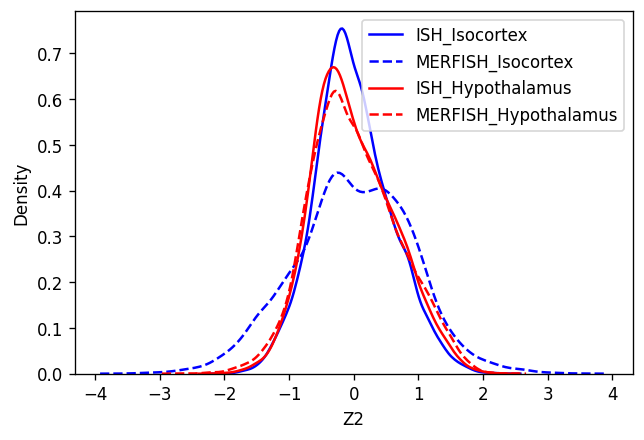

In [260]:
plt.figure(dpi=120)
sns.kdeplot(ISH_IC_AllGenes, label="ISH_Isocortex", color="blue")
sns.kdeplot(MERFISH_IC_AllGenes, label="MERFISH_Isocortex", color="blue", ls="--")
sns.kdeplot(ISH_HY_AllGenes, label="ISH_Hypothalamus", color="red")
sns.kdeplot(MERFISH_HY_AllGenes, label="MERFISH_Hypothalamus", color="red", ls="--")
plt.legend()
plt.xlabel("Z2")

In [261]:
# Is that a sibling thing? what about randome genes? 
# Or maybe due to weight distribution?

In [336]:
##### Is hypothalamus over-represent in MERFISH?
Dir1 = "/home/jw3514/Work/ASD_Circuits/dat/CTRL/RandomGenes/ISH_STR"
Dir2 = "/home/jw3514/Work/ASD_Circuits/dat/CTRL/RandomGenes/MERFISH_STR"
Sib_Isocortex_ISH = []
Sib_Isocortex_Merfish = []
Sib_Hypothalamus_ISH = []
Sib_Hypothalamus_Merfish = []
for i in range(1000):
    Pair1 = pd.read_csv("{}/cont.bias.{}.csv".format(Dir1, i), index_col=0)
    Pair2 = pd.read_csv("{}/cont.bias.{}.csv".format(Dir2, i), index_col=0)
    Sib_Isocortex_ISH.append(Pair1[Pair1["REGION"]=="Isocortex"]["EFFECT"].mean())
    Sib_Isocortex_Merfish.append(Pair2[Pair2["REGION"]=="Isocortex"]["EFFECT"].mean())
    Sib_Hypothalamus_ISH.append(Pair1[Pair1["REGION"]=="Hypothalamus"]["EFFECT"].mean())
    Sib_Hypothalamus_Merfish.append(Pair2[Pair2["REGION"]=="Hypothalamus"]["EFFECT"].mean())

Text(0.5, 1.0, 'RandomGenes')

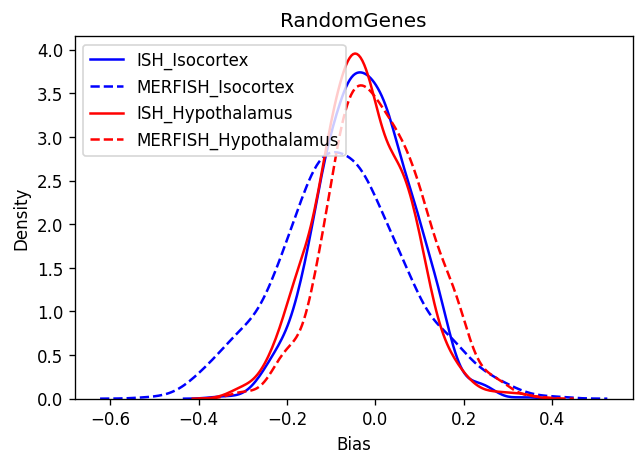

In [337]:
plt.figure(dpi=120)
sns.kdeplot(Sib_Isocortex_ISH, label="ISH_Isocortex", color="blue")
sns.kdeplot(Sib_Isocortex_Merfish, label="MERFISH_Isocortex", color="blue", ls="--")
sns.kdeplot(Sib_Hypothalamus_ISH, label="ISH_Hypothalamus", color="red")
sns.kdeplot(Sib_Hypothalamus_Merfish, label="MERFISH_Hypothalamus", color="red", ls="--")
plt.legend()
plt.xlabel("Bias")
plt.title("RandomGenes")

#### Bias as ASD - Sib

In [266]:
ASD_Bias_MERFISH_Z2_Cell.head(10)

,EFFECT,REGION,Rank
STR,,,
Main_olfactory_bulb,0.629272,Olfactory_areas,1
Olfactory_tubercle,0.514145,Striatum,2
Intercalated_amygdalar_nucleus,0.496814,Amygdalar,3
Central_lobule,0.468420,Cerebellum,4
Culmen,0.450593,Cerebellum,5
Subparaventricular_zone,0.445709,Hypothalamus,6
Dorsomedial_nucleus_of_the_hypothalamus,0.439140,Hypothalamus,7
Simple_lobule,0.434898,Cerebellum,8
Nucleus_accumbens,0.434166,Striatum,9


In [324]:
def FixSubiculum(DF):
    X = DF.loc["Subiculum_dorsal_part"]
    Y = DF.loc["Subiculum_ventral_part"]
    Z = [(X[0]+Y[0])/2, "Hippocampus", 214]
    DF.loc["Subiculum"] = Z
    DF = DF.drop(["Subiculum_dorsal_part", "Subiculum_ventral_part"])
    return DF

In [325]:
STRs = ASD_Bias_MERFISH_Z2_Cell.index.values
data = []
for i in range(1000):
    Pair1 = pd.read_csv("{}/cont.bias.{}.csv".format(Dir1, i), index_col=0)
    Pair1 = FixSubiculum(Pair1)
    Pair1 = Pair1.loc[STRs,:]
    biases = Pair1["EFFECT"].values
    data.append(biases)
data = np.array(data)
sib_bias_df_ISH = pd.DataFrame(data=data, columns=STRs)

In [268]:
# Get Sibling MERFISH STR biases
Dir2 = "/home/jw3514/Work/ASD_Circuits/dat/CTRL/SubSampleSib_w_GeneProb/MERFISH_STR"
STRs = ASD_Bias_MERFISH_Z2_Cell.index.values
data = []
for i in range(1000):
    Pair2 = pd.read_csv("{}/cont.bias.{}.csv".format(Dir2, i), index_col=0)
    Pair2 = Pair2.loc[STRs,:]
    biases = Pair2["EFFECT"].values
    data.append(biases)
data = np.array(data)
sib_bias_df = pd.DataFrame(data=data, columns=STRs)

In [269]:
sib_bias_df.head(2)

,Main_olfactory_bulb,Olfactory_tubercle,Intercalated_amygdalar_nucleus,Central_lobule,Culmen,Subparaventricular_zone,Dorsomedial_nucleus_of_the_hypothalamus,Simple_lobule,Nucleus_accumbens,Bed_nuclei_of_the_stria_terminalis,...,Septofimbrial_nucleus,Substantia_nigra_compact_part,Ventral_cochlear_nucleus,Principal_sensory_nucleus_of_the_trigeminal,Facial_motor_nucleus,Tegmental_reticular_nucleus,Hypoglossal_nucleus,Pontine_gray,Motor_nucleus_of_trigeminal,Anterodorsal_nucleus
0,0.209789,0.233902,0.218789,0.317767,0.337918,-0.002040,0.075413,0.332817,0.105909,0.112562,...,-0.050613,-0.201807,-0.015075,0.041544,0.155543,-0.090427,0.185253,-0.207339,0.449634,-0.141714
1,-0.041592,-0.014339,-0.048464,0.187324,0.165111,-0.018328,-0.060482,0.158682,0.072981,-0.002073,...,-0.032563,0.161990,0.224704,0.101641,0.189413,0.024563,0.149850,-0.123908,0.103552,-0.117164


In [278]:
for _str, row in ASD_Bias_MERFISH_Z2_Cell.iterrows():
    EFFECT = row["EFFECT"]
    mean_sib = sib_bias_df[_str].mean()
    Effect2 = EFFECT - mean_sib
    ASD_Bias_MERFISH_Z2_Cell.loc[_str, "EFFECT2"] = Effect2

In [293]:
ASD_Bias_MERFISH_Z2_Cell2 = ASD_Bias_MERFISH_Z2_Cell.sort_values("EFFECT2", ascending=False)
ASD_Bias_MERFISH_Z2_Cell2.rename(columns={'EFFECT2': 'EFFECT', 'EFFECT': 'EFFECT_old'}, inplace=True)
ASD_Bias_MERFISH_Z2_Cell2["Rank"] = ASD_Bias_MERFISH_Z2_Cell2['EFFECT'].rank(ascending=False)

In [286]:
#ASD_Bias_MERFISH_Z2_Cell2.head(50)

In [294]:
GetBiasCorrelation_STR(ASD_STR_ISH_Bias, ASD_Bias_MERFISH_Z2_Cell2)

(0.6474011917037348, 0.5923582848180725)

(0.4297868461725924, 6.107146567910567e-11)


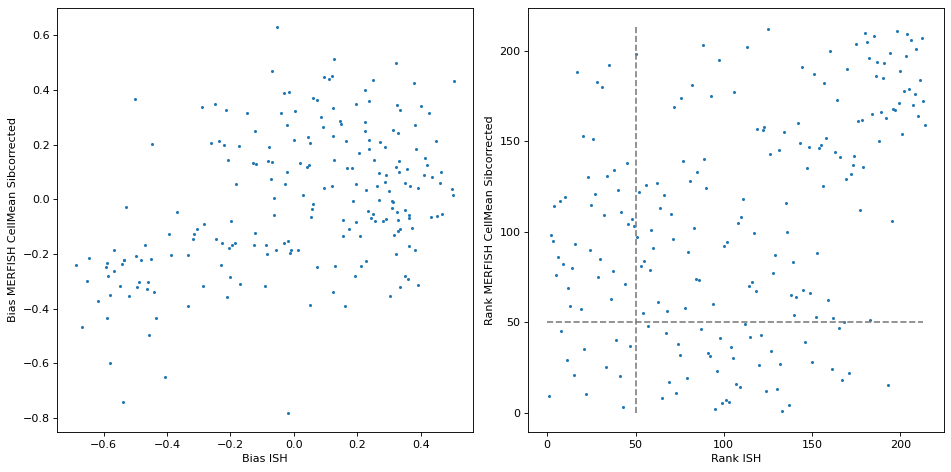

In [297]:
BiasCorrelation(ASD_STR_ISH_Bias, ASD_Bias_MERFISH_Z2_Cell, "ISH", "MERFISH CellMean Sibcorrected")

(0.6474011917037348, 1.4281307361145868e-26)


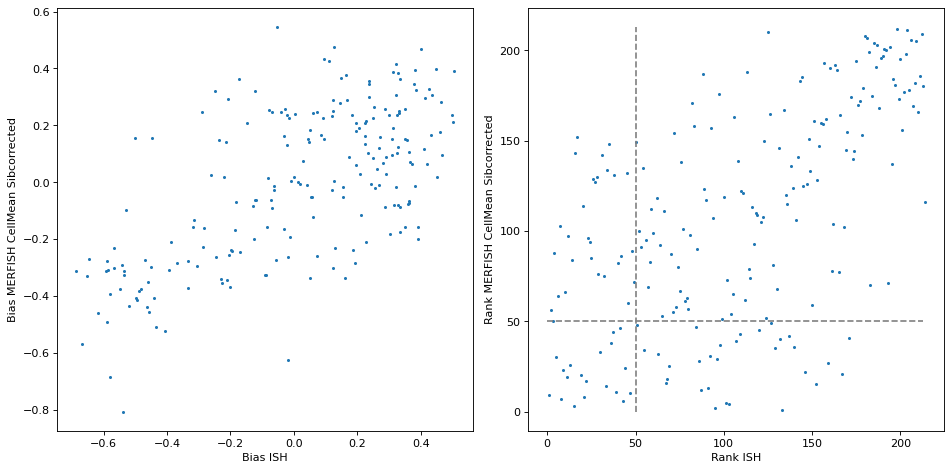

In [296]:
BiasCorrelation(ASD_STR_ISH_Bias, ASD_Bias_MERFISH_Z2_Cell2, "ISH", "MERFISH CellMean Sibcorrected")

In [291]:
ISH_top50 = set(ASD_STR_ISH_Bias.index.values[:50])
MERFISH_top50 = set(ASD_Bias_MERFISH_Z2_Cell2.index.values[:50])
ISH_top50.intersection(MERFISH_top50)

{'Anterior_olfactory_nucleus',
 'Anteromedial_visual_area',
 'Basomedial_amygdalar_nucleus',
 'Bed_nuclei_of_the_stria_terminalis',
 'Caudoputamen',
 'Claustrum',
 'Endopiriform_nucleus_dorsal_part',
 'Endopiriform_nucleus_ventral_part',
 'Gustatory_areas',
 'Intercalated_amygdalar_nucleus',
 'Lateral_visual_area',
 'Nucleus_accumbens',
 'Orbital_area_medial_part',
 'Orbital_area_ventrolateral_part',
 'Posterior_parietal_association_areas',
 'Prelimbic_area',
 'Primary_visual_area',
 'Retrosplenial_area_lateral_agranular_part',
 'Subparafascicular_nucleus_magnocellular_part',
 'Visceral_area',
 'posteromedial_visual_area'}

In [292]:
len(ISH_top50.intersection(MERFISH_top50))

21

In [298]:
ASD_Bias_MERFISH_Z2_Cell.to_csv("ASD_Bias_MERFISH_Z2_Cell.csv")

In [299]:
STR2CellNumber = pd.read_csv("STR2CellNumber.csv", index_col=0)

In [301]:
STR2CellNumber.head(5)

,REGION,STR_name,STR_ncell
STR,,,
Main_olfactory_bulb,Olfactory_areas,Main olfactory bulb,77675.0
Olfactory_tubercle,Striatum,Olfactory tubercle,30300.0
Anterior_olfactory_nucleus,Olfactory_areas,Anterior olfactory nucleus,37612.0
Subparaventricular_zone,Hypothalamus,Subparaventricular zone,1441.0
Dorsomedial_nucleus_of_the_hypothalamus,Hypothalamus,Dorsomedial nucleus of the hypothalamus,4698.0


In [328]:
for i, row in STR2CellNumber.iterrows():
    mean_sib = sib_bias_df[i].mean()
    STR2CellNumber.loc[i, "MeanSibBias"] = mean_sib
    mean_sib_ISH = sib_bias_df_ISH[i].mean()
    STR2CellNumber.loc[i, "MeanSibBias_ISH"] = mean_sib_ISH

In [330]:
HY = STR2CellNumber[STR2CellNumber["REGION"]=="Hypothalamus"]
CTX = STR2CellNumber[STR2CellNumber["REGION"]=="Isocortex"]
CB = STR2CellNumber[STR2CellNumber["REGION"]=="Cerebellum"]
MB = STR2CellNumber[STR2CellNumber["REGION"]=="Midbrain"]

SpearmanrResult(correlation=-0.20077966755981702, pvalue=0.0033239964415617794)
-0.042864510954378904 0.1606393678581824
SpearmanrResult(correlation=-0.2471063162141539, pvalue=0.0002799760419689152)
-0.0172188873514567 0.06518447752055204


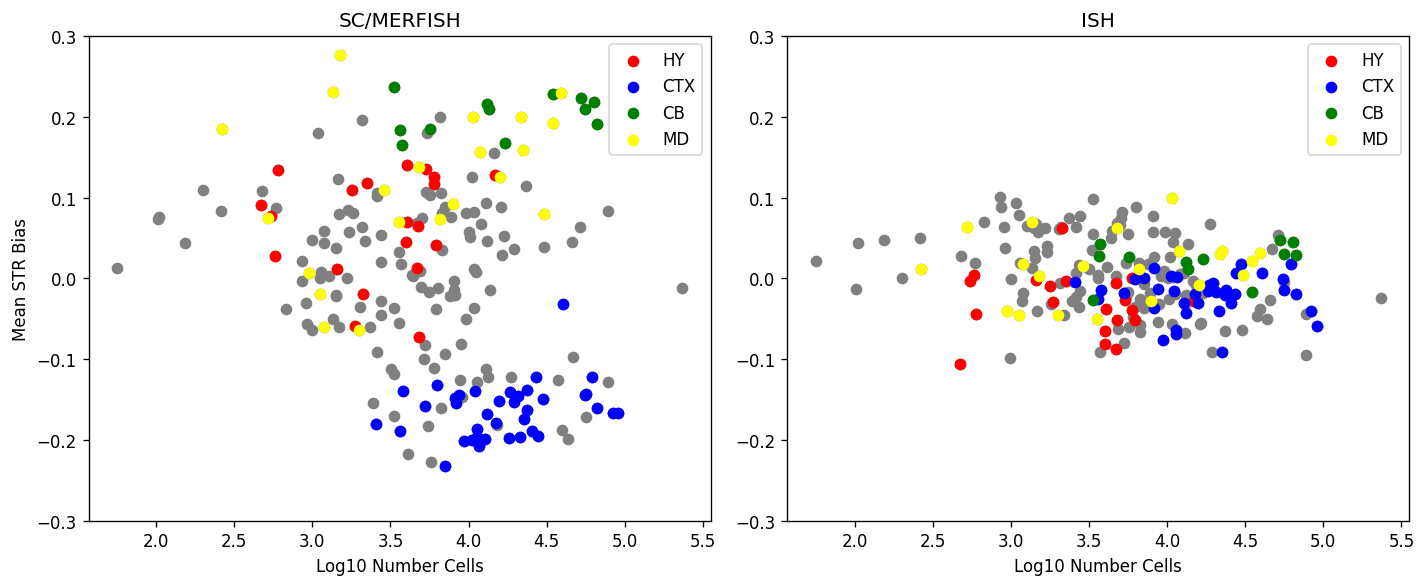

In [358]:
fig, ax = plt.subplots(1,2, dpi=120, figsize=(12,5))

X = np.log10(STR2CellNumber["STR_ncell"].values)
Y = STR2CellNumber["MeanSibBias"].values
ax[0].scatter(X,Y, color="grey")
print(spearmanr(X,Y))
m,b = np.polyfit(X, Y, 1)
print(m,b)

X1 = np.log10(HY["STR_ncell"].values)
Y1 = HY["MeanSibBias"].values
ax[0].scatter(X1,Y1, color="red", label="HY")

X2 = np.log10(CTX["STR_ncell"].values)
Y2 = CTX["MeanSibBias"].values
ax[0].scatter(X2,Y2, color="blue", label="CTX")

X2 = np.log10(CB["STR_ncell"].values)
Y2 = CB["MeanSibBias"].values
ax[0].scatter(X2,Y2, color="green", label="CB")

X2 = np.log10(MB["STR_ncell"].values)
Y2 = MB["MeanSibBias"].values
ax[0].scatter(X2,Y2, color="yellow", label="MD")

X = np.log10(STR2CellNumber["STR_ncell"].values)
Y = STR2CellNumber["MeanSibBias_ISH"].values
ax[1].scatter(X,Y, color="grey")
print(spearmanr(X,Y))
m,b = np.polyfit(X, Y, 1)
print(m,b)

X1 = np.log10(HY["STR_ncell"].values)
Y1 = HY["MeanSibBias_ISH"].values
ax[1].scatter(X1,Y1, color="red", label="HY")

X2 = np.log10(CTX["STR_ncell"].values)
Y2 = CTX["MeanSibBias_ISH"].values
ax[1].scatter(X2,Y2, color="blue", label="CTX")

X2 = np.log10(CB["STR_ncell"].values)
Y2 = CB["MeanSibBias_ISH"].values
ax[1].scatter(X2,Y2, color="green", label="CB")

X2 = np.log10(MB["STR_ncell"].values)
Y2 = MB["MeanSibBias_ISH"].values
ax[1].scatter(X2,Y2, color="yellow", label="MD")

ax[0].set_ylim(-0.3, 0.3)
ax[1].set_ylim(-0.3, 0.3)
ax[0].set_ylabel("Mean STR Bias")
ax[0].set_xlabel("Log10 Number Cells")
ax[1].set_xlabel("Log10 Number Cells")

ax[0].set_title("SC/MERFISH")
ax[1].set_title("ISH")
plt.tight_layout()
ax[0].legend()
ax[1].legend()

In [357]:
m,b = np.polyfit(X, Y, 1)
print(m,b)

-0.0172188873514567 0.06518447752055204


In [308]:
spearmanr(X,Y)

SpearmanrResult(correlation=-0.20077966755981702, pvalue=0.0033239964415617794)

In [314]:
STR2CellNumber = STR2CellNumber.sort_values("MeanSibBias")

In [322]:
STR2CellNumber.tail(20)

,REGION,STR_name,STR_ncell,MeanSibBias
STR,,,,
Pontine_central_gray,Pons,Pontine central gray,5434.0,0.179374
Fastigial_nucleus,Cerebellum,Fastigial nucleus,3650.0,0.183538
Interposed_nucleus,Cerebellum,Interposed nucleus,5675.0,0.184999
Medial_pretectal_area,Midbrain,Medial pretectal area,265.0,0.185396
Ansiform_lobule,Cerebellum,Ansiform lobule,66400.0,0.190859
Periaqueductal_gray,Midbrain,Periaqueductal gray,34974.0,0.192318
Ventral_part_of_the_lateral_geniculate_complex,Thalamus,Ventral part of the lateral geniculate complex,2077.0,0.195521
Anterior_pretectal_nucleus,Midbrain,Anterior pretectal nucleus,10711.0,0.199616
Dorsal_cochlear_nucleus,Medulla,Dorsal cochlear nucleus,6570.0,0.199622


# Test Zmatch

In [508]:
MERFISH_CellMean_Zmatch = pd.read_csv("dat/MERFISH/Z2Mat.ABCMatch.ISH_STR.CellMean.Zmatch.csv", index_col=0)
MERFISH_VolMean_Zmatch = pd.read_csv("dat/MERFISH/Z2Mat.ABCMatch.ISH_STR.VolMean.Zmatch.csv", index_col=0)

In [509]:
MERFISH_CellMean_Zmatch.head(2)

,Frontal pole cerebral cortex,Primary motor area,Secondary motor area,Primary somatosensory area nose,Primary somatosensory area barrel field,Primary somatosensory area lower limb,Primary somatosensory area mouth,Primary somatosensory area upper limb,Primary somatosensory area trunk,Supplemental somatosensory area,...,Pyramus VIII,Nodulus X,Simple lobule,Ansiform lobule,Paramedian lobule,Paraflocculus,Flocculus,Fastigial nucleus,Interposed nucleus,Dentate nucleus
4026,-1.103152,-0.788175,-0.669207,-0.910768,-0.917817,-0.942183,-0.787517,-0.844397,-0.757809,-0.787117,...,2.455985,3.110659,3.037396,2.737194,2.562955,3.170617,3.081379,1.406860,1.206988,1.734076
285386,-0.480113,-0.484124,-0.481188,-0.551955,-0.514318,-0.493507,-0.495301,-0.511084,-0.485542,-0.518883,...,-0.106475,-0.092387,-0.092400,-0.100971,-0.115467,-0.084274,-0.096100,-0.075153,-0.090266,-0.050028


In [510]:
MERFISH_VolMean_Zmatch.head(2)

,Frontal pole cerebral cortex,Primary motor area,Secondary motor area,Primary somatosensory area nose,Primary somatosensory area barrel field,Primary somatosensory area lower limb,Primary somatosensory area mouth,Primary somatosensory area upper limb,Primary somatosensory area trunk,Supplemental somatosensory area,...,Pyramus VIII,Nodulus X,Simple lobule,Ansiform lobule,Paramedian lobule,Paraflocculus,Flocculus,Fastigial nucleus,Interposed nucleus,Dentate nucleus
4026,-1.103152,-0.788175,-0.669207,-0.910768,-0.917817,-0.942183,-0.787517,-0.844397,-0.757809,-0.787117,...,2.455985,3.110659,3.037396,2.737194,2.562955,3.170617,3.081379,1.406860,1.206988,1.734076
285386,-0.480113,-0.484124,-0.481188,-0.551955,-0.514318,-0.493507,-0.495301,-0.511084,-0.485542,-0.518883,...,-0.106475,-0.092387,-0.092400,-0.100971,-0.115467,-0.084274,-0.096100,-0.075153,-0.090266,-0.050028


In [511]:
head = MERFISH_CellMean_Zmatch.columns.values
new_head = [X.replace(" ", "_") for X in head]
MERFISH_CellMean_Zmatch.columns = new_head
MERFISH_VolMean_Zmatch.columns = new_head

In [512]:
ASD_Bias_MERFISH_test = AvgSTRZ_Weighted(MERFISH_CellMean_Zmatch, ASD_GW)
ASD_Bias_MERFISH_test2 = AvgSTRZ_Weighted(MERFISH_VolMean_Zmatch, ASD_GW)

In [513]:
ASD_Bias_MERFISH_test.head(10)

,EFFECT,REGION,Rank
STR,,,
Main_olfactory_bulb,0.757390,Olfactory_areas,1
Anterior_olfactory_nucleus,0.715538,Olfactory_areas,2
Endopiriform_nucleus_ventral_part,0.664657,Cortical_subplate,3
Olfactory_tubercle,0.659515,Striatum,4
Nucleus_of_the_lateral_olfactory_tract,0.658571,Olfactory_areas,5
Intercalated_amygdalar_nucleus,0.655488,Amygdala,6
Central_lobule,0.655248,Cerebellum,7
Culmen,0.653717,Cerebellum,8
Simple_lobule,0.649608,Cerebellum,9


In [514]:
ASD_Bias_MERFISH_test2.head(10)

,EFFECT,REGION,Rank
STR,,,
Main_olfactory_bulb,0.757390,Olfactory_areas,1
Anterior_olfactory_nucleus,0.715538,Olfactory_areas,2
Endopiriform_nucleus_ventral_part,0.664657,Cortical_subplate,3
Olfactory_tubercle,0.659515,Striatum,4
Nucleus_of_the_lateral_olfactory_tract,0.658571,Olfactory_areas,5
Intercalated_amygdalar_nucleus,0.655488,Amygdala,6
Central_lobule,0.655248,Cerebellum,7
Culmen,0.653717,Cerebellum,8
Simple_lobule,0.649608,Cerebellum,9


In [515]:
#ASD_Bias_MERFISH_test.head(50)

(0.7371523744736032, 1.3272673384196448e-37)


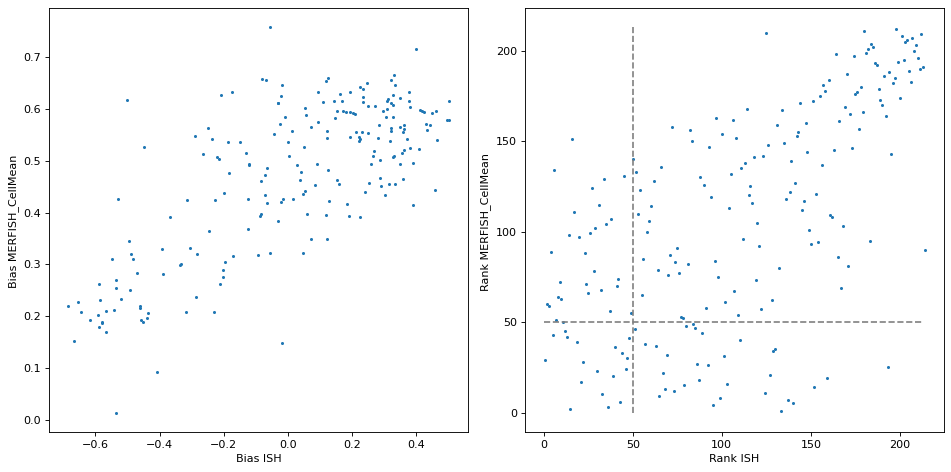

In [516]:
BiasCorrelation(ASD_STR_ISH_Bias, ASD_Bias_MERFISH_test, "ISH", "MERFISH_CellMean ")

(0.737152374473599, 1.32726733842155e-37)


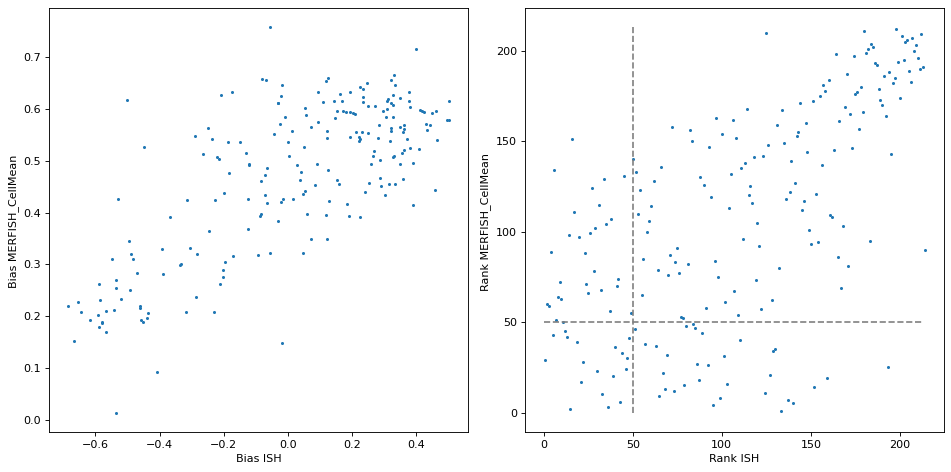

In [517]:
BiasCorrelation(ASD_STR_ISH_Bias, ASD_Bias_MERFISH_test2, "ISH", "MERFISH_CellMean ")

# Test Median

In [465]:
MERFISH_Median_CellMean_Exp = pd.read_csv("dat/MERFISH_Median/STR_Cell_Mean_DF.csv", index_col=0)
MERFISH_Median_VolMean_Exp = pd.read_csv("dat/MERFISH_Median/STR_Vol_Mean_DF.csv", index_col=0)

In [470]:
MERFISH_Median_CellMean_Exp_qn = quantileNormalize(MERFISH_Median_CellMean_Exp)

In [471]:
MERFISH_Median_CellMean_Exp_Z1 = Z1Conversion(MERFISH_Median_CellMean_Exp_qn)

/home/jw3514/Work/CellType_Psy/src/ASD_Circuits.py:70: RuntimeWarning: invalid value encountered in double_scalars
  z = (x - mean)/std


In [472]:
MERFISH_Median_CellMean_Exp_Z1_qn = quantileNormalize(MERFISH_Median_CellMean_Exp_Z1)

In [474]:
head = MERFISH_Median_CellMean_Exp_Z1_qn.columns.values
new_head = [X.replace(" ", "_") for X in head]
MERFISH_Median_CellMean_Exp_Z1_qn.columns = new_head

In [475]:
ASD_Bias_MERFISH_test = AvgSTRZ_Weighted(MERFISH_Median_CellMean_Exp_Z1_qn, ASD_GW)

In [477]:
ASD_Bias_MERFISH_test.head(50)

,EFFECT,REGION,Rank
STR,,,
Substantia_innominata,0.713927,Pallidum,1
Interpeduncular_nucleus,0.578830,Midbrain,2
Main_olfactory_bulb,0.565446,Olfactory_areas,3
Peripeduncular_nucleus,0.554040,Thalamus,4
Subparafascicular_nucleus_parvicellular_part,0.504917,Thalamus,5
Fundus_of_striatum,0.485820,Striatum,6
Lateral_hypothalamic_area,0.474037,Hypothalamus,7
Parabrachial_nucleus,0.455354,Pons,8
Bed_nuclei_of_the_stria_terminalis,0.446117,Pallidum,9


In [466]:
MERFISH_Median_CellMean_Exp_Z1 = Z1Conversion(MERFISH_Median_CellMean_Exp)
MERFISH_Median_VolMean_Exp_Z1 = Z1Conversion(MERFISH_Median_VolMean_Exp)

/home/jw3514/Work/CellType_Psy/src/ASD_Circuits.py:70: RuntimeWarning: invalid value encountered in double_scalars
  z = (x - mean)/std
/home/jw3514/Work/CellType_Psy/src/ASD_Circuits.py:70: RuntimeWarning: invalid value encountered in double_scalars
  z = (x - mean)/std


In [467]:
MERFISH_Median_CellMean_Exp_Z1_v2 = pd.read_csv("dat/MERFISH_Median/STR_Cell_Mean_DF.Z1.csv", index_col=0)
MERFISH_Median_VolMean_Exp_Z1_v2 = pd.read_csv("dat/MERFISH_Median/STR_Vol_Mean_DF.Z1.csv", index_col=0)

In [468]:
MERFISH_Median_CellMean_Exp_Z1.head(2)

,Frontal pole cerebral cortex,Primary motor area,Secondary motor area,Primary somatosensory area nose,Primary somatosensory area barrel field,Primary somatosensory area lower limb,Primary somatosensory area mouth,Primary somatosensory area upper limb,Primary somatosensory area trunk,Supplemental somatosensory area,...,Pyramus VIII,Nodulus X,Simple lobule,Ansiform lobule,Paramedian lobule,Paraflocculus,Flocculus,Fastigial nucleus,Interposed nucleus,Dentate nucleus
114786,0.919900,0.399639,0.227384,0.723721,0.754063,0.818576,0.614046,0.661853,0.556493,0.535856,...,0.472500,-0.175292,0.384769,0.312256,0.082028,-0.082501,-1.008771,-1.798673,-1.909018,-1.594401
6101,-0.193904,-0.193904,-0.193904,-0.193904,-0.193904,-0.193904,-0.193904,-0.193904,-0.193904,-0.193904,...,-0.193904,0.661895,-0.193904,-0.193904,-0.193904,0.249352,1.562347,-0.193904,-0.193904,-0.193904


In [469]:
MERFISH_Median_CellMean_Exp_Z1_v2.head(2)

,Frontal pole cerebral cortex,Primary motor area,Secondary motor area,Primary somatosensory area nose,Primary somatosensory area barrel field,Primary somatosensory area lower limb,Primary somatosensory area mouth,Primary somatosensory area upper limb,Primary somatosensory area trunk,Supplemental somatosensory area,...,Pyramus VIII,Nodulus X,Simple lobule,Ansiform lobule,Paramedian lobule,Paraflocculus,Flocculus,Fastigial nucleus,Interposed nucleus,Dentate nucleus
114786,0.919900,0.399639,0.227384,0.723721,0.754063,0.818576,0.614046,0.661853,0.556493,0.535856,...,0.472500,-0.175292,0.384769,0.312256,0.082028,-0.082501,-1.008771,-1.798673,-1.909018,-1.594401
6101,-0.193904,-0.193904,-0.193904,-0.193904,-0.193904,-0.193904,-0.193904,-0.193904,-0.193904,-0.193904,...,-0.193904,0.661895,-0.193904,-0.193904,-0.193904,0.249352,1.562347,-0.193904,-0.193904,-0.193904


In [450]:
#MERFISH_Median_CellMean = pd.read_csv("dat/MERFISH_Median/SC_STR_CellMean.Z2.csv", index_col=0)
#MERFISH_Median_CellMean = pd.read_csv("dat/MERFISH_Median/SC_STR_CellMean.Z2.ABCMatch.csv", index_col=0)
MERFISH_Median_CellMean = pd.read_csv("dat/MERFISH_Median/Z2Mat.ABCMatch.ISH_STR.MedianV3.CellMean.SCMatch.csv", index_col=0)
#MERFISH_Median_VolMean = pd.read_csv("dat/MERFISH_Median/SC_STR_VolMean.Z2.csv", index_col=0)
MERFISH_Median_VolMean = pd.read_csv("dat/MERFISH_Median/Z2Mat.ABCMatch.ISH_STR.MedianV3.VolMean.SCMatch.csv", index_col=0)

#MERFISH_Median_CellMean = pd.read_csv("dat/MERFISH_Median/STR_Cell_Mean_DF.Z1.csv", index_col=0)
#MERFISH_Median_VolMean = pd.read_csv("dat/MERFISH_Median/STR_Vol_Mean_DF.Z1.csv", index_col=0)

head = MERFISH_Median_CellMean.columns.values
new_head = [X.replace(" ", "_") for X in head]
MERFISH_Median_CellMean.columns = new_head
MERFISH_Median_VolMean.columns = new_head

In [451]:
ASD_Genes = list(ASD_GW.keys())

In [452]:
#MERFISH_Median_CellMean.loc[ASD_Genes, "Nucleus_accumbens"].hist()
#MERFISH_Median_CellMean.loc[ASD_Genes, "Field_CA1"].hist()

In [453]:
ASD_Bias_MERFISH_Median1 = AvgSTRZ_Weighted(MERFISH_Median_CellMean, ASD_GW)
ASD_Bias_MERFISH_Median2 = AvgSTRZ_Weighted(MERFISH_Median_VolMean, ASD_GW)

In [459]:
ASD_Bias_MERFISH_Median2.head(50)

,EFFECT,REGION,Rank
STR,,,
Central_lobule,0.571497,Cerebellum,1
Simple_lobule,0.559109,Cerebellum,2
Culmen,0.557833,Cerebellum,3
Nodulus_X,0.506147,Cerebellum,4
Ansiform_lobule,0.498644,Cerebellum,5
Paraflocculus,0.436950,Cerebellum,6
Main_olfactory_bulb,0.433283,Olfactory_areas,7
Flocculus,0.372810,Cerebellum,8
Subparafascicular_area,0.350019,Thalamus,9


(-0.0013004765846802257, 0.9849820806173432)


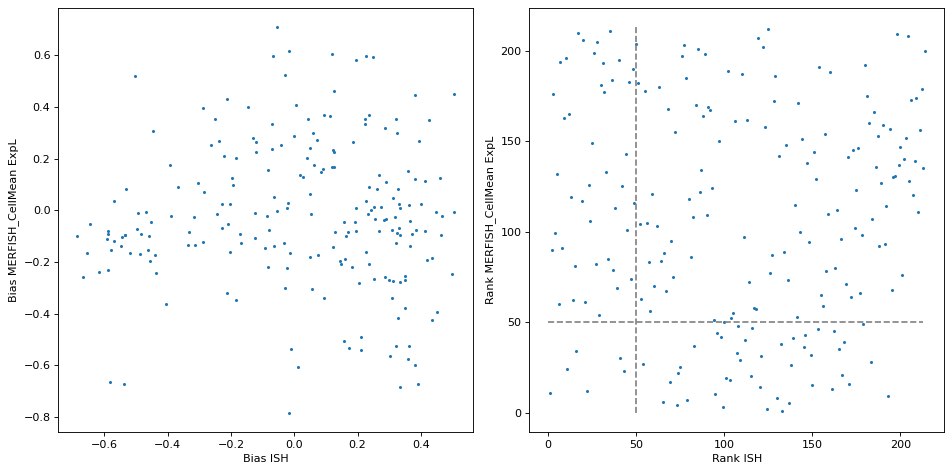

In [455]:
BiasCorrelation(ASD_STR_ISH_Bias, ASD_Bias_MERFISH_Median1, "ISH", "MERFISH_CellMean ExpL")

(-0.02819525709061174, 0.6831392218951411)


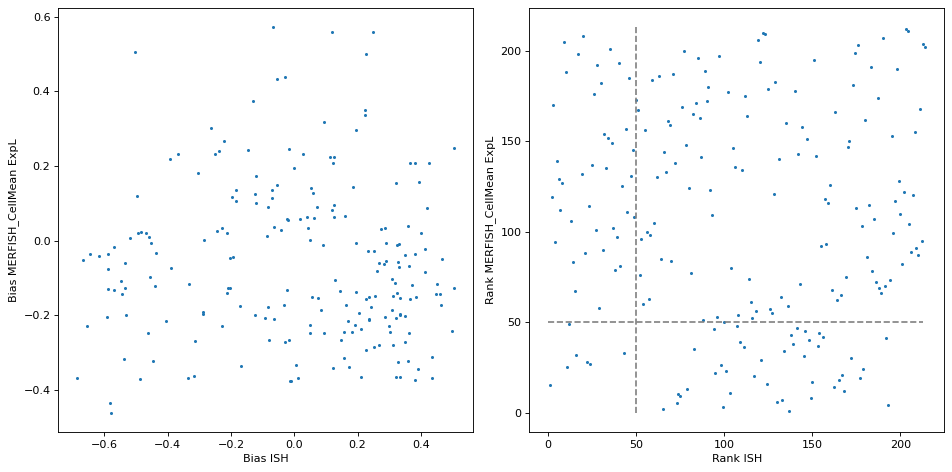

In [457]:
BiasCorrelation(ASD_STR_ISH_Bias, ASD_Bias_MERFISH_Median2, "ISH", "MERFISH_CellMean ExpL")